In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from impyute.imputation.cs import mice
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

In [3]:
#pip install impyute

<H1>Import Data

In [4]:
data = pd.read_csv('train.csv')
df = data.copy()
test = pd.read_csv('test (1).csv')

<AxesSubplot:>

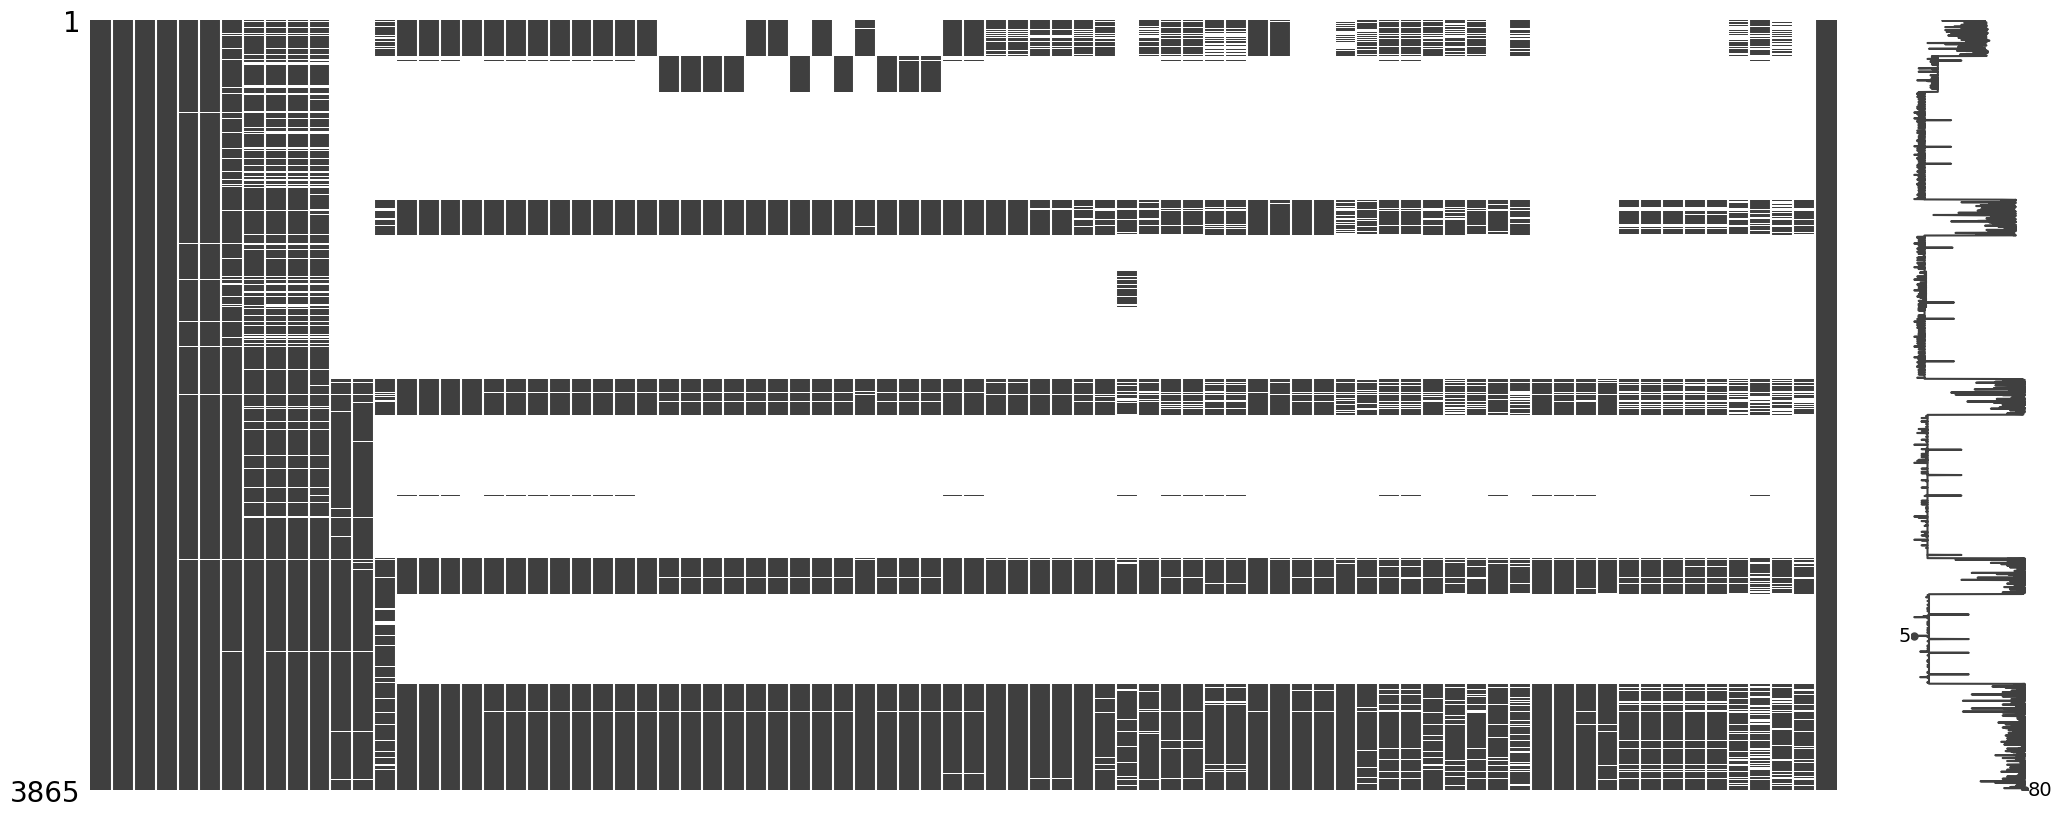

In [5]:
msno.matrix(df)

In [6]:
df.isnull().sum()

galactic year                                                                   0
galaxy                                                                          0
existence expectancy index                                                      1
existence expectancy at birth                                                   1
Gross income per capita                                                        28
                                                                             ... 
Adjusted net savings                                                         2953
Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total    2924
Private galaxy capital flows (% of GGP)                                      2991
Gender Inequality Index (GII)                                                3021
y                                                                               0
Length: 80, dtype: int64

<H3>Let's see how much data is missing in the training dataset

In [7]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
Gender Inequality Index (GII),3021,0.781630
Current health expenditure (% of GGP),2998,0.775679
"Interstellar Data Net users, total (% of population)",2993,0.774386
Private galaxy capital flows (% of GGP),2991,0.773868
Interstellar phone subscriptions (per 100 people),2974,0.769470


In [8]:
df

,galactic year,galaxy,existence expectancy index,existence expectancy at birth,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,...,"Intergalactic Development Index (IDI), female","Intergalactic Development Index (IDI), male",Gender Development Index (GDI),"Intergalactic Development Index (IDI), female, Rank","Intergalactic Development Index (IDI), male, Rank",Adjusted net savings,"Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total",Private galaxy capital flows (% of GGP),Gender Inequality Index (GII),y
0,990025,Large Magellanic Cloud (LMC),0.628657,63.125200,27109.234310,0.646039,8.240543,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.052590
1,990025,Camelopardalis B,0.818082,81.004994,30166.793958,0.852246,10.671823,4.742470,0.833624,0.467873,...,NaN,NaN,NaN,NaN,NaN,19.177926,NaN,22.785018,NaN,0.059868
2,990025,Virgo I,0.659443,59.570534,8441.707353,0.499762,8.840316,5.583973,0.469110,0.363837,...,NaN,NaN,NaN,NaN,NaN,21.151265,6.534020,NaN,NaN,0.050449
3,990025,UGC 8651 (DDO 181),0.555862,52.333293,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.912194,NaN,NaN,0.049394
4,990025,Tucana Dwarf,0.991196,81.802464,81033.956906,1.131163,13.800672,13.188907,0.910341,0.918353,...,NaN,NaN,NaN,NaN,NaN,NaN,5.611753,NaN,NaN,0.154247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3860,1015056,Columba I,1.029704,82.832063,34310.471408,0.855094,18.578586,10.557143,0.906573,0.862826,...,0.943410,0.902237,1.060532,124.564121,143.907576,26.438719,3.023709,29.294865,0.580785,0.042324
3861,1015056,"Leo II Dwarf (Leo B, DDO 93)",0.937869,75.877098,36899.067719,0.929494,16.153857,9.151665,0.865822,0.747577,...,0.915225,0.798083,1.055118,163.664516,184.291155,20.637654,4.470596,31.085400,0.517558,0.036725
3862,1015056,Canes Venatici I Dwarf,1.036144,93.540275,37002.977875,1.085245,21.066473,16.661344,0.983835,1.100779,...,1.097208,1.044890,1.114754,66.498714,112.887035,28.154859,5.193997,32.145570,0.363862,0.166271
3863,1015056,KKs 3,0.939034,78.274427,28180.459770,0.687655,9.388911,8.908748,0.735694,0.602703,...,0.596164,0.754729,0.825864,182.249079,175.408953,38.963157,2.854140,27.227179,0.711878,0.024187


<H3>Drop column where null values more than 500

In [9]:
for i in df.columns:
    if df[f'{i}'].isnull().sum() > 500:
        df.drop(df[[f'{i}']], axis = 1, inplace = True)

<H3>I use here mice imputation because of lack of time (Train Data)

In [10]:
train_to_mice = df.drop('galaxy', axis=1)
imputed_training = mice(train_to_mice.values)
train_mice = pd.DataFrame(data = imputed_training, columns = train_to_mice.columns.tolist())

In [11]:
train_mice['galaxy'] = df['galaxy']

In [12]:
train_mice.columns

Index(['galactic year', 'existence expectancy index',
       'existence expectancy at birth', 'Gross income per capita',
       'Income Index', 'Expected years of education (galactic years)',
       'Mean years of education (galactic years)',
       'Intergalactic Development Index (IDI)', 'Education Index',
       'Intergalactic Development Index (IDI), Rank', 'y', 'galaxy'],
      dtype='object')

In [13]:
new_list = ['galactic year', 'galaxy', 'existence expectancy index',
       'existence expectancy at birth', 'Gross income per capita',
       'Income Index', 'Expected years of education (galactic years)',
       'Mean years of education (galactic years)',
       'Intergalactic Development Index (IDI)', 'Education Index',
       'Intergalactic Development Index (IDI), Rank', 'y']

In [14]:
train_mice = train_mice[new_list]

In [15]:
train_mice['galaxy'].nunique()

181

In [16]:
test['galaxy'].nunique()

172

<AxesSubplot:>

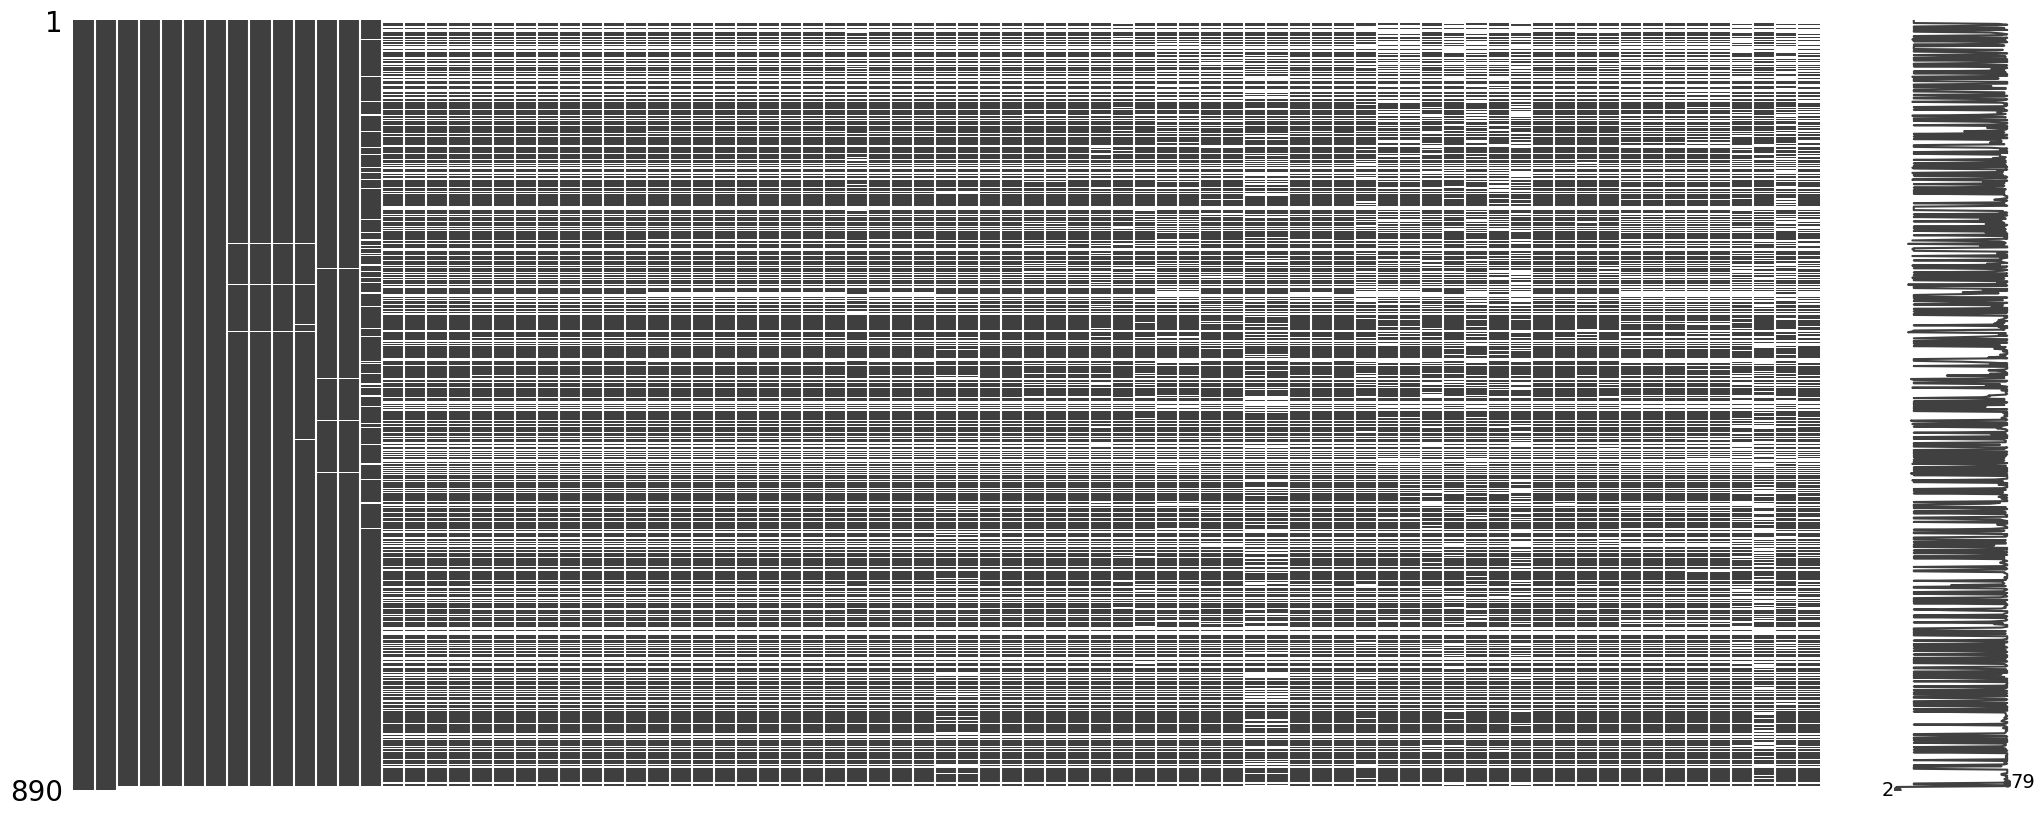

In [17]:
msno.matrix(test)

In [18]:
test.isnull().sum()

galactic year                                                                  0
galaxy                                                                         0
existence expectancy index                                                     5
existence expectancy at birth                                                  5
Gross income per capita                                                        5
                                                                            ... 
Intergalactic Development Index (IDI), male, Rank                            341
Adjusted net savings                                                         371
Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total    408
Private galaxy capital flows (% of GGP)                                      354
Gender Inequality Index (GII)                                                361
Length: 79, dtype: int64

<H3>Drop column where null values more than 500 (Test Data)

In [19]:
for i in test.columns:
    if test[f'{i}'].isnull().sum() > 500:
        test.drop(test[[f'{i}']], axis = 1, inplace = True)

In [20]:
test_list = new_list[0:len(new_list) - 1]
test = test[test_list]

<AxesSubplot:>

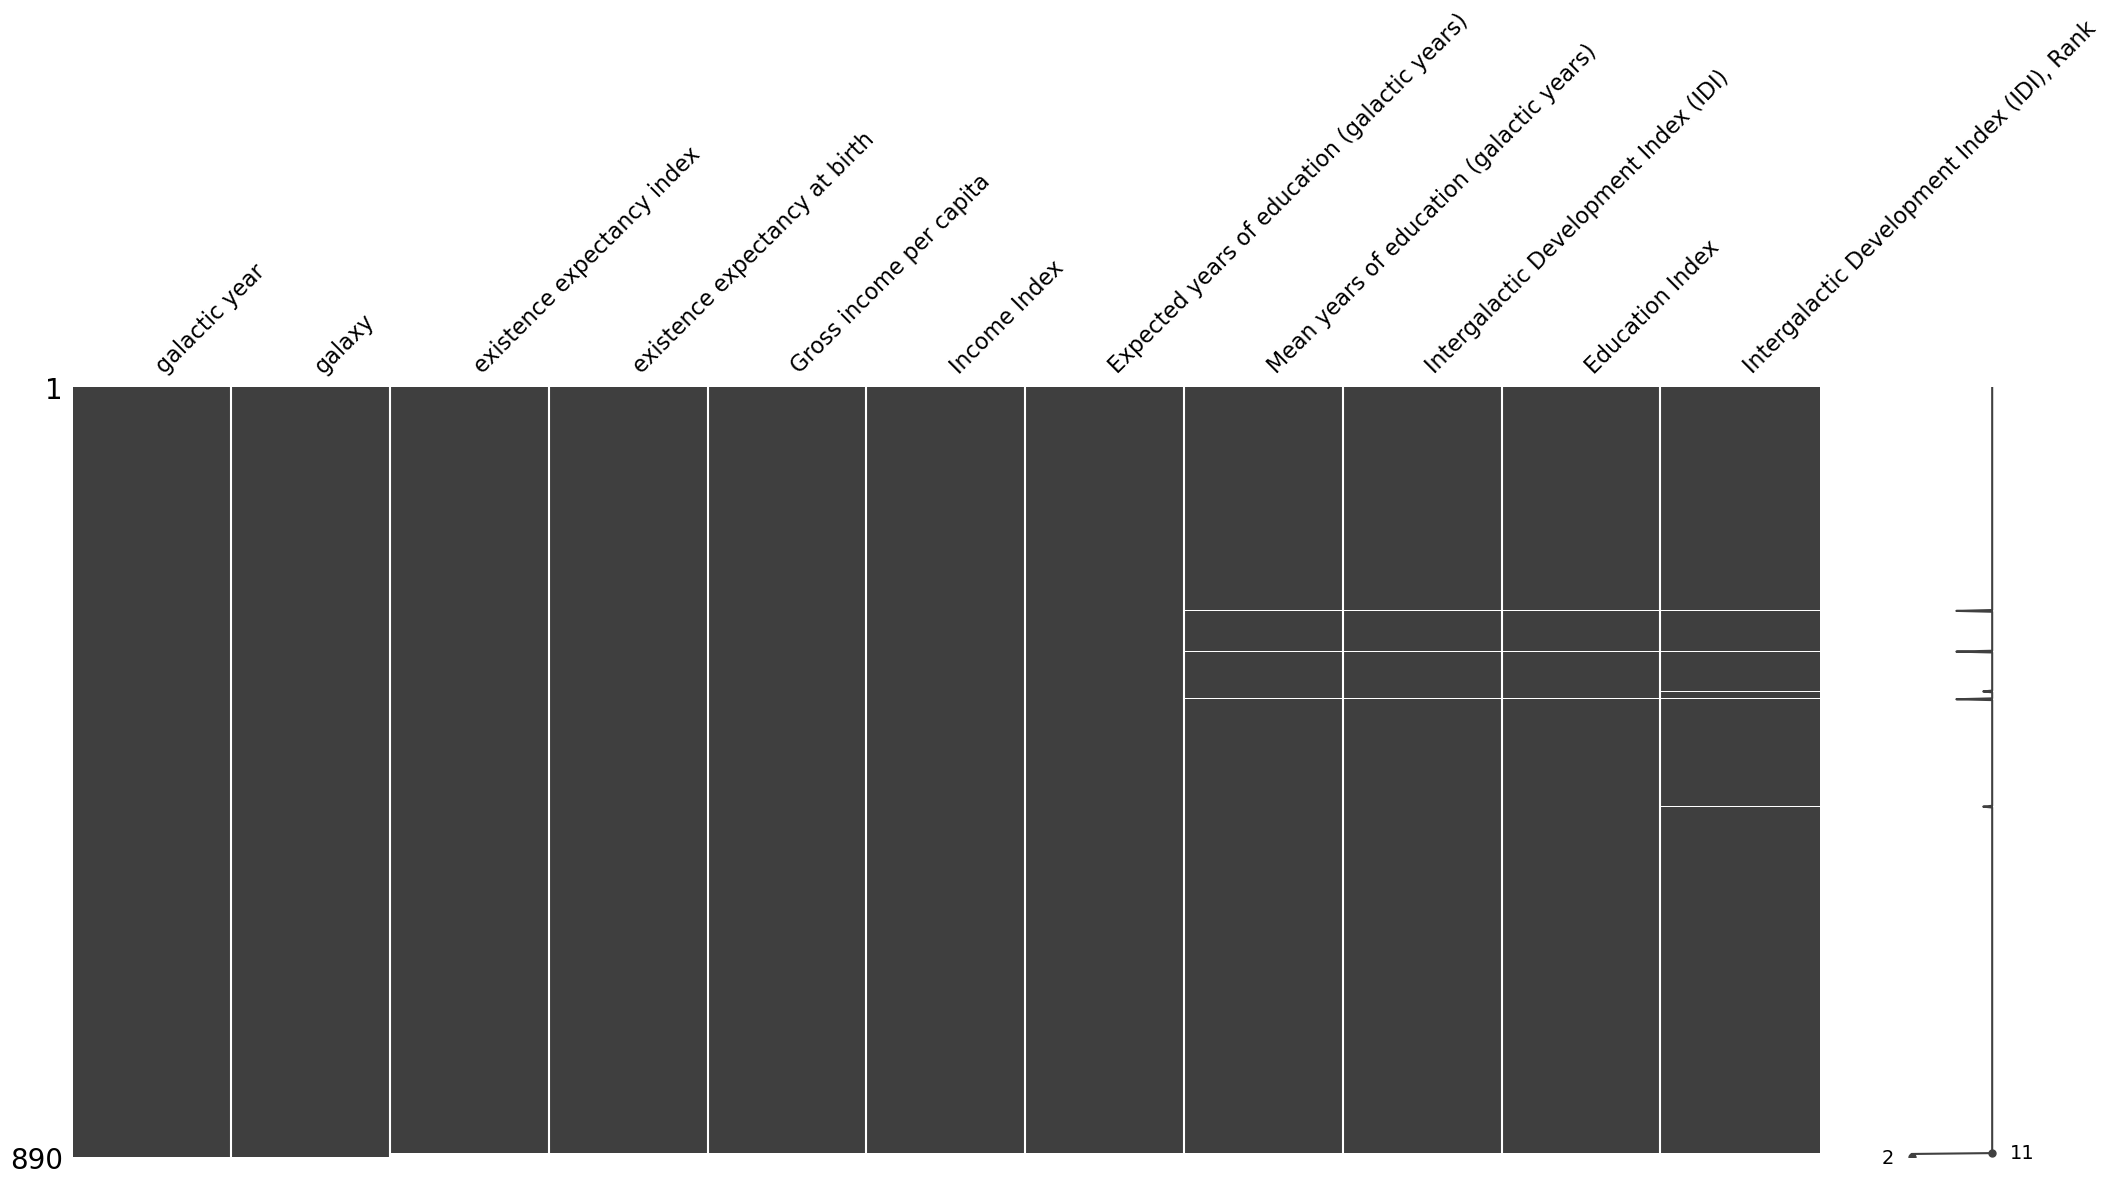

In [21]:
msno.matrix(test)

<AxesSubplot:>

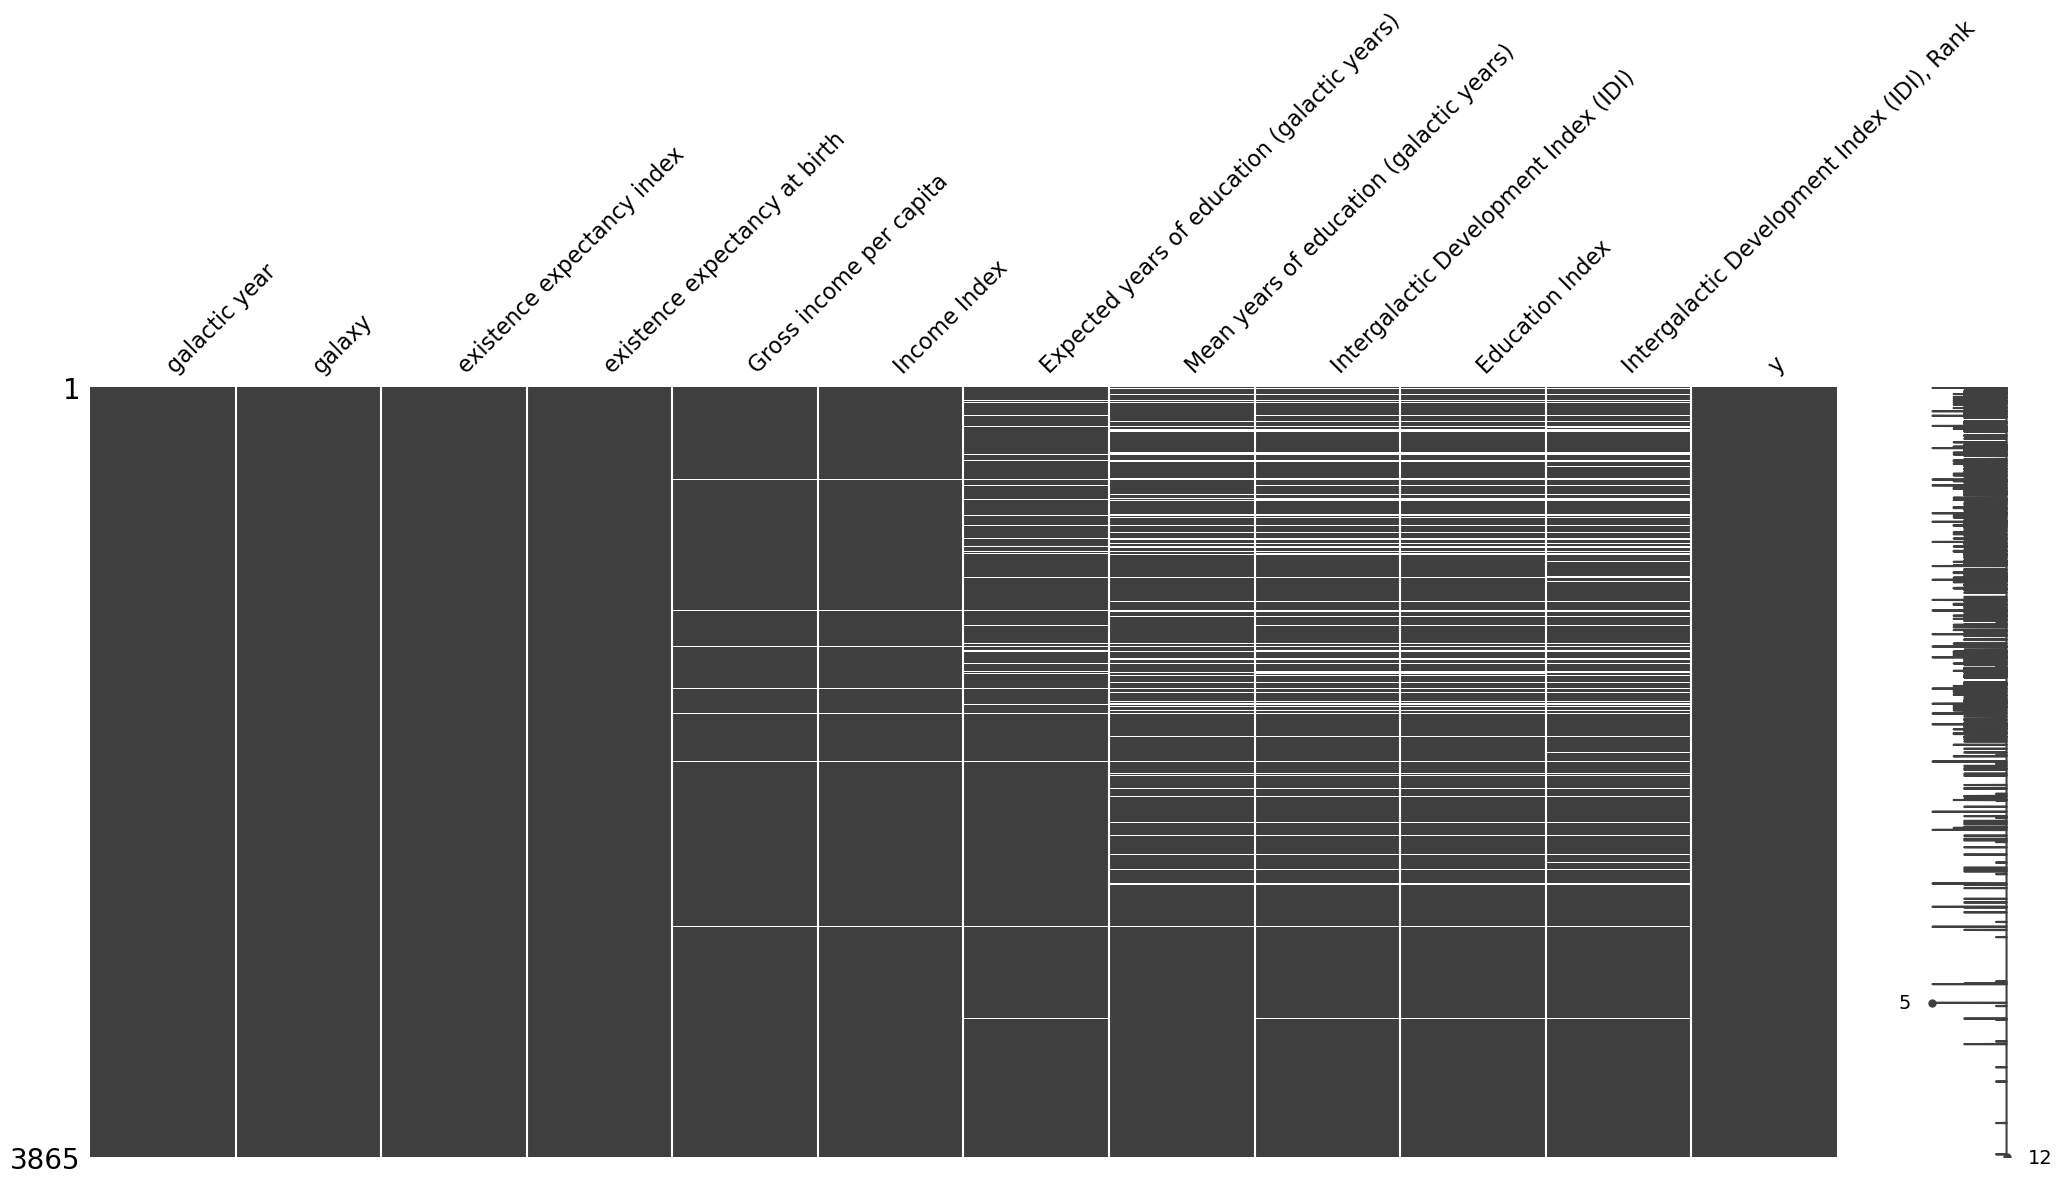

In [22]:
msno.matrix(df)

Text(0.5, 1.0, 'Features Correlating with y column')

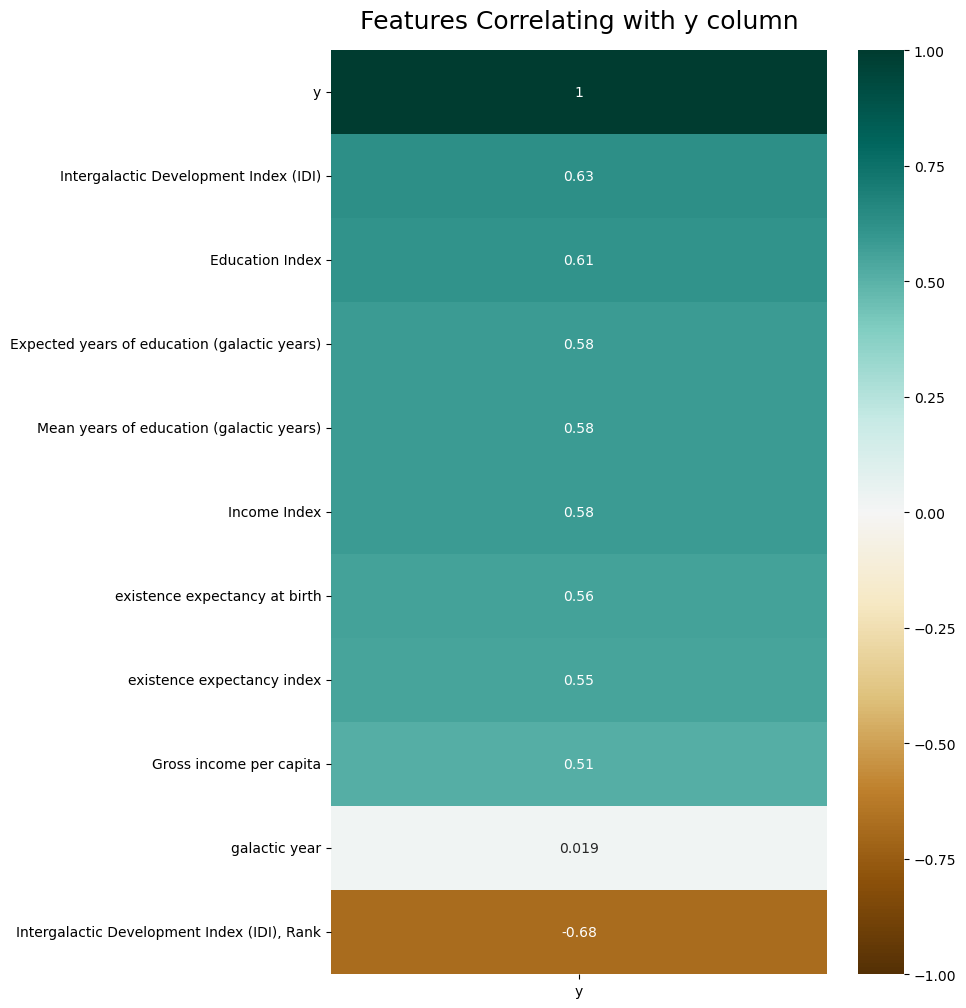

In [23]:
plt.figure(figsize = (8, 12))
heatmap = sns.heatmap(df.corr()[['y']].sort_values(by = 'y', ascending=False), vmin = -1, vmax = 1, annot = True, cmap = 'BrBG')
heatmap.set_title('Features Correlating with y column', fontdict = {'fontsize':18}, pad = 16)

<H3>To check same Galaxy in Train and Test Data

In [24]:
same_values = []
for i in list(test['galaxy']):
    for j in list(train_mice['galaxy']):
        if i == j and i not in same_values:
            same_values.append(i)

<H3>Delete Galaxy that are not in the Test Data

In [25]:
for i in train_mice['galaxy']:
    if i not in same_values:
        train_mice.drop(train_mice[train_mice['galaxy'] == i].index, inplace = True)
df=train_mice

In [26]:
df

,galactic year,galaxy,existence expectancy index,existence expectancy at birth,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,"Intergalactic Development Index (IDI), Rank",y
0,990025.0,Large Magellanic Cloud (LMC),0.628657,63.125200,27109.234310,0.646039,8.240543,6.026469,0.554802,0.454903,173.835439,0.052590
1,990025.0,Camelopardalis B,0.818082,81.004994,30166.793958,0.852246,10.671823,4.742470,0.833624,0.467873,152.522198,0.059868
2,990025.0,Virgo I,0.659443,59.570534,8441.707353,0.499762,8.840316,5.583973,0.469110,0.363837,209.813266,0.050449
3,990025.0,UGC 8651 (DDO 181),0.555862,52.333293,17849.191182,0.612144,10.479207,7.074436,0.555231,0.550866,176.552545,0.049394
5,990025.0,KKh 060,0.824692,63.887135,28409.062695,0.671697,14.062458,9.978597,0.815264,0.796807,121.839696,0.052871
...,...,...,...,...,...,...,...,...,...,...,...,...
3860,1015056.0,Columba I,1.029704,82.832063,34310.471408,0.855094,18.578586,10.557143,0.906573,0.862826,144.896214,0.042324
3861,1015056.0,"Leo II Dwarf (Leo B, DDO 93)",0.937869,75.877098,36899.067719,0.929494,16.153857,9.151665,0.865822,0.747577,164.692000,0.036725
3862,1015056.0,Canes Venatici I Dwarf,1.036144,93.540275,37002.977875,1.085245,21.066473,16.661344,0.983835,1.100779,63.726437,0.166271
3863,1015056.0,KKs 3,0.939034,78.274427,28180.459770,0.687655,9.388911,8.908748,0.735694,0.602703,216.805701,0.024187


<H3>One-Hot Encode

In [27]:
train_dummies = pd.get_dummies(df['galaxy'])
test_dummies = pd.get_dummies(test['galaxy'])

In [28]:
df.shape

(3664, 12)

In [29]:
df.isnull().sum()

galactic year                                   0
galaxy                                          0
existence expectancy index                      0
existence expectancy at birth                   0
Gross income per capita                         0
Income Index                                    0
Expected years of education (galactic years)    0
Mean years of education (galactic years)        0
Intergalactic Development Index (IDI)           0
Education Index                                 0
Intergalactic Development Index (IDI), Rank     0
y                                               0
dtype: int64

In [30]:
test.isnull().sum()

galactic year                                    0
galaxy                                           0
existence expectancy index                       5
existence expectancy at birth                    5
Gross income per capita                          5
Income Index                                     5
Expected years of education (galactic years)     5
Mean years of education (galactic years)         8
Intergalactic Development Index (IDI)            8
Education Index                                  8
Intergalactic Development Index (IDI), Rank     10
dtype: int64

<H3>Features and Target

In [31]:
df.drop('galaxy', axis = 1, inplace = True)
X = df.drop(['y'], axis = 1)
y = df['y']

<H3>I use here mice imputation because of lack of time (Test Data)

In [32]:
test_to_mice = test.drop('galaxy', axis = 1)
imputed_training = mice(test_to_mice.values)
test = pd.DataFrame(data = imputed_training, columns = test_to_mice.columns.tolist())

<H3>Encoded columns was joined Datas

In [33]:
X_joined_dummies = X.join(train_dummies)
df_test_joined_dummies = test.join(test_dummies)

In [34]:
X = X_joined_dummies
df_test_pred = df_test_joined_dummies

<H3>Rename columns with galaxies from alphabetic names to numbers

In [35]:
galaxy_rename_list = train_dummies.columns.tolist()
i = 1
for name in galaxy_rename_list:
    X.rename(columns = {name: i}, inplace = True)
    df_test_pred.rename(columns = {name: i}, inplace = True)
    i = i + 1

<H1>Modelling

<H4>To find the parameters

In [36]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)

# model = CatBoostRegressor()
# parameters = {'depth'         : [3, 4, 5],
#               'learning_rate' : [0.05, 0.1, 0.2],
#               'iterations'    : [8000, 12000],
#               'subsample'     : [0.3, 0.5, 1]
#             }
# grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs = -1)
# grid.fit(X_train, y_train)    

# # # Results from Grid Search
# print("\n========================================================")
# print(" Results from Grid Search " )
# print("========================================================")    
    
# print("\n The best estimator across ALL searched params:\n",
#     grid.best_estimator_)
    
# print("\n The best score across ALL searched params:\n",
#     grid.best_score_)
    
# print("\n The best parameters across ALL searched params:\n",
#     grid.best_params_)
    


In [37]:
#  Results from Grid Search 

#  The best score across ALL searched params:
#  0.945926489807116


#  The best parameters across ALL searched params:
#  {'depth': 3, 'iterations': 12000, 'learning_rate': 0.05, 'subsample': 0.3}

#  

<H3>Model with the best parameters

In [38]:
model = CatBoostRegressor(iterations=12000,
                          learning_rate=0.05,
                          subsample=0.3,
                          depth=3)

In [39]:
model.fit(X_train,y_train)

0:	learn: 0.0616969	total: 136ms	remaining: 27m 10s
1:	learn: 0.0598185	total: 139ms	remaining: 13m 51s
2:	learn: 0.0581414	total: 141ms	remaining: 9m 22s
3:	learn: 0.0565680	total: 143ms	remaining: 7m 7s
4:	learn: 0.0550113	total: 145ms	remaining: 5m 47s
5:	learn: 0.0536188	total: 147ms	remaining: 4m 53s
6:	learn: 0.0523487	total: 149ms	remaining: 4m 14s
7:	learn: 0.0511264	total: 151ms	remaining: 3m 45s
8:	learn: 0.0499725	total: 152ms	remaining: 3m 22s
9:	learn: 0.0487805	total: 154ms	remaining: 3m 5s
10:	learn: 0.0476036	total: 156ms	remaining: 2m 50s
11:	learn: 0.0465065	total: 163ms	remaining: 2m 42s
12:	learn: 0.0454743	total: 165ms	remaining: 2m 32s
13:	learn: 0.0445069	total: 168ms	remaining: 2m 23s
14:	learn: 0.0436162	total: 170ms	remaining: 2m 16s
15:	learn: 0.0427570	total: 172ms	remaining: 2m 8s
16:	learn: 0.0419137	total: 174ms	remaining: 2m 2s
17:	learn: 0.0411221	total: 176ms	remaining: 1m 57s
18:	learn: 0.0403940	total: 179ms	remaining: 1m 52s
19:	learn: 0.0397070	tot

200:	learn: 0.0186849	total: 539ms	remaining: 31.6s
201:	learn: 0.0186533	total: 541ms	remaining: 31.6s
202:	learn: 0.0186231	total: 544ms	remaining: 31.6s
203:	learn: 0.0185931	total: 546ms	remaining: 31.6s
204:	learn: 0.0185641	total: 548ms	remaining: 31.6s
205:	learn: 0.0185363	total: 551ms	remaining: 31.6s
206:	learn: 0.0185102	total: 555ms	remaining: 31.6s
207:	learn: 0.0184859	total: 557ms	remaining: 31.6s
208:	learn: 0.0184583	total: 559ms	remaining: 31.6s
209:	learn: 0.0184323	total: 562ms	remaining: 31.5s
210:	learn: 0.0184037	total: 563ms	remaining: 31.5s
211:	learn: 0.0183795	total: 565ms	remaining: 31.4s
212:	learn: 0.0183548	total: 567ms	remaining: 31.4s
213:	learn: 0.0183281	total: 569ms	remaining: 31.3s
214:	learn: 0.0183017	total: 571ms	remaining: 31.3s
215:	learn: 0.0182802	total: 573ms	remaining: 31.3s
216:	learn: 0.0182556	total: 575ms	remaining: 31.2s
217:	learn: 0.0182337	total: 576ms	remaining: 31.2s
218:	learn: 0.0182075	total: 578ms	remaining: 31.1s
219:	learn: 

429:	learn: 0.0145806	total: 1.12s	remaining: 30.2s
430:	learn: 0.0145721	total: 1.12s	remaining: 30.2s
431:	learn: 0.0145647	total: 1.13s	remaining: 30.1s
432:	learn: 0.0145564	total: 1.13s	remaining: 30.2s
433:	learn: 0.0145471	total: 1.13s	remaining: 30.1s
434:	learn: 0.0145360	total: 1.13s	remaining: 30.1s
435:	learn: 0.0145181	total: 1.14s	remaining: 30.1s
436:	learn: 0.0145050	total: 1.14s	remaining: 30.1s
437:	learn: 0.0144963	total: 1.14s	remaining: 30.1s
438:	learn: 0.0144793	total: 1.14s	remaining: 30.1s
439:	learn: 0.0144625	total: 1.14s	remaining: 30.1s
440:	learn: 0.0144517	total: 1.15s	remaining: 30s
441:	learn: 0.0144436	total: 1.15s	remaining: 30s
442:	learn: 0.0144331	total: 1.15s	remaining: 30s
443:	learn: 0.0144229	total: 1.15s	remaining: 30s
444:	learn: 0.0144131	total: 1.16s	remaining: 30s
445:	learn: 0.0143978	total: 1.16s	remaining: 30s
446:	learn: 0.0143885	total: 1.16s	remaining: 30s
447:	learn: 0.0143772	total: 1.17s	remaining: 30s
448:	learn: 0.0143701	total:

651:	learn: 0.0124927	total: 1.71s	remaining: 29.8s
652:	learn: 0.0124832	total: 1.71s	remaining: 29.8s
653:	learn: 0.0124758	total: 1.72s	remaining: 29.8s
654:	learn: 0.0124679	total: 1.72s	remaining: 29.8s
655:	learn: 0.0124563	total: 1.72s	remaining: 29.8s
656:	learn: 0.0124459	total: 1.73s	remaining: 29.8s
657:	learn: 0.0124380	total: 1.73s	remaining: 29.8s
658:	learn: 0.0124299	total: 1.73s	remaining: 29.8s
659:	learn: 0.0124236	total: 1.73s	remaining: 29.8s
660:	learn: 0.0124181	total: 1.73s	remaining: 29.8s
661:	learn: 0.0124116	total: 1.74s	remaining: 29.7s
662:	learn: 0.0124061	total: 1.74s	remaining: 29.7s
663:	learn: 0.0123933	total: 1.74s	remaining: 29.7s
664:	learn: 0.0123855	total: 1.74s	remaining: 29.7s
665:	learn: 0.0123753	total: 1.75s	remaining: 29.7s
666:	learn: 0.0123710	total: 1.75s	remaining: 29.7s
667:	learn: 0.0123654	total: 1.75s	remaining: 29.7s
668:	learn: 0.0123574	total: 1.75s	remaining: 29.7s
669:	learn: 0.0123512	total: 1.76s	remaining: 29.7s
670:	learn: 

910:	learn: 0.0108582	total: 2.28s	remaining: 27.8s
911:	learn: 0.0108540	total: 2.28s	remaining: 27.8s
912:	learn: 0.0108498	total: 2.28s	remaining: 27.7s
913:	learn: 0.0108442	total: 2.29s	remaining: 27.7s
914:	learn: 0.0108376	total: 2.29s	remaining: 27.7s
915:	learn: 0.0108327	total: 2.29s	remaining: 27.7s
916:	learn: 0.0108298	total: 2.29s	remaining: 27.7s
917:	learn: 0.0108217	total: 2.29s	remaining: 27.7s
918:	learn: 0.0108176	total: 2.3s	remaining: 27.7s
919:	learn: 0.0108142	total: 2.3s	remaining: 27.7s
920:	learn: 0.0108100	total: 2.3s	remaining: 27.7s
921:	learn: 0.0108067	total: 2.3s	remaining: 27.6s
922:	learn: 0.0108036	total: 2.3s	remaining: 27.6s
923:	learn: 0.0107986	total: 2.31s	remaining: 27.6s
924:	learn: 0.0107926	total: 2.31s	remaining: 27.6s
925:	learn: 0.0107872	total: 2.31s	remaining: 27.6s
926:	learn: 0.0107832	total: 2.31s	remaining: 27.6s
927:	learn: 0.0107798	total: 2.31s	remaining: 27.6s
928:	learn: 0.0107764	total: 2.31s	remaining: 27.6s
929:	learn: 0.010

1156:	learn: 0.0098118	total: 2.66s	remaining: 24.9s
1157:	learn: 0.0098080	total: 2.66s	remaining: 24.9s
1158:	learn: 0.0098010	total: 2.67s	remaining: 24.9s
1159:	learn: 0.0097981	total: 2.67s	remaining: 24.9s
1160:	learn: 0.0097921	total: 2.67s	remaining: 24.9s
1161:	learn: 0.0097825	total: 2.67s	remaining: 24.9s
1162:	learn: 0.0097793	total: 2.67s	remaining: 24.9s
1163:	learn: 0.0097768	total: 2.68s	remaining: 24.9s
1164:	learn: 0.0097738	total: 2.68s	remaining: 24.9s
1165:	learn: 0.0097706	total: 2.68s	remaining: 24.9s
1166:	learn: 0.0097683	total: 2.68s	remaining: 24.9s
1167:	learn: 0.0097621	total: 2.68s	remaining: 24.9s
1168:	learn: 0.0097561	total: 2.68s	remaining: 24.9s
1169:	learn: 0.0097491	total: 2.69s	remaining: 24.9s
1170:	learn: 0.0097454	total: 2.69s	remaining: 24.9s
1171:	learn: 0.0097437	total: 2.69s	remaining: 24.8s
1172:	learn: 0.0097412	total: 2.69s	remaining: 24.8s
1173:	learn: 0.0097354	total: 2.69s	remaining: 24.8s
1174:	learn: 0.0097298	total: 2.69s	remaining:

1328:	learn: 0.0092080	total: 3.03s	remaining: 24.4s
1329:	learn: 0.0092043	total: 3.04s	remaining: 24.4s
1330:	learn: 0.0092019	total: 3.04s	remaining: 24.3s
1331:	learn: 0.0091998	total: 3.04s	remaining: 24.4s
1332:	learn: 0.0091980	total: 3.04s	remaining: 24.4s
1333:	learn: 0.0091944	total: 3.04s	remaining: 24.3s
1334:	learn: 0.0091929	total: 3.05s	remaining: 24.3s
1335:	learn: 0.0091843	total: 3.05s	remaining: 24.3s
1336:	learn: 0.0091814	total: 3.05s	remaining: 24.3s
1337:	learn: 0.0091775	total: 3.05s	remaining: 24.3s
1338:	learn: 0.0091742	total: 3.06s	remaining: 24.3s
1339:	learn: 0.0091713	total: 3.06s	remaining: 24.3s
1340:	learn: 0.0091664	total: 3.06s	remaining: 24.3s
1341:	learn: 0.0091635	total: 3.06s	remaining: 24.3s
1342:	learn: 0.0091579	total: 3.06s	remaining: 24.3s
1343:	learn: 0.0091559	total: 3.06s	remaining: 24.3s
1344:	learn: 0.0091540	total: 3.07s	remaining: 24.3s
1345:	learn: 0.0091509	total: 3.07s	remaining: 24.3s
1346:	learn: 0.0091483	total: 3.07s	remaining:

1519:	learn: 0.0086221	total: 3.4s	remaining: 23.4s
1520:	learn: 0.0086194	total: 3.4s	remaining: 23.5s
1521:	learn: 0.0086145	total: 3.41s	remaining: 23.5s
1522:	learn: 0.0086126	total: 3.41s	remaining: 23.5s
1523:	learn: 0.0086085	total: 3.41s	remaining: 23.4s
1524:	learn: 0.0086053	total: 3.41s	remaining: 23.4s
1525:	learn: 0.0086023	total: 3.42s	remaining: 23.5s
1526:	learn: 0.0086008	total: 3.42s	remaining: 23.5s
1527:	learn: 0.0085986	total: 3.42s	remaining: 23.5s
1528:	learn: 0.0085975	total: 3.42s	remaining: 23.4s
1529:	learn: 0.0085954	total: 3.42s	remaining: 23.4s
1530:	learn: 0.0085941	total: 3.43s	remaining: 23.4s
1531:	learn: 0.0085905	total: 3.43s	remaining: 23.4s
1532:	learn: 0.0085885	total: 3.43s	remaining: 23.4s
1533:	learn: 0.0085865	total: 3.43s	remaining: 23.4s
1534:	learn: 0.0085848	total: 3.43s	remaining: 23.4s
1535:	learn: 0.0085813	total: 3.44s	remaining: 23.4s
1536:	learn: 0.0085786	total: 3.44s	remaining: 23.4s
1537:	learn: 0.0085769	total: 3.44s	remaining: 2

1710:	learn: 0.0081186	total: 3.79s	remaining: 22.8s
1711:	learn: 0.0081144	total: 3.79s	remaining: 22.8s
1712:	learn: 0.0081110	total: 3.79s	remaining: 22.8s
1713:	learn: 0.0081074	total: 3.79s	remaining: 22.7s
1714:	learn: 0.0081050	total: 3.79s	remaining: 22.7s
1715:	learn: 0.0081031	total: 3.79s	remaining: 22.7s
1716:	learn: 0.0081016	total: 3.79s	remaining: 22.7s
1717:	learn: 0.0080984	total: 3.8s	remaining: 22.7s
1718:	learn: 0.0080969	total: 3.8s	remaining: 22.7s
1719:	learn: 0.0080949	total: 3.8s	remaining: 22.7s
1720:	learn: 0.0080930	total: 3.8s	remaining: 22.7s
1721:	learn: 0.0080910	total: 3.81s	remaining: 22.7s
1722:	learn: 0.0080877	total: 3.81s	remaining: 22.7s
1723:	learn: 0.0080866	total: 3.81s	remaining: 22.7s
1724:	learn: 0.0080851	total: 3.82s	remaining: 22.7s
1725:	learn: 0.0080828	total: 3.82s	remaining: 22.7s
1726:	learn: 0.0080816	total: 3.82s	remaining: 22.7s
1727:	learn: 0.0080789	total: 3.83s	remaining: 22.8s
1728:	learn: 0.0080770	total: 3.83s	remaining: 22.

1882:	learn: 0.0077331	total: 4.16s	remaining: 22.3s
1883:	learn: 0.0077299	total: 4.16s	remaining: 22.3s
1884:	learn: 0.0077289	total: 4.16s	remaining: 22.3s
1885:	learn: 0.0077278	total: 4.16s	remaining: 22.3s
1886:	learn: 0.0077241	total: 4.16s	remaining: 22.3s
1887:	learn: 0.0077211	total: 4.16s	remaining: 22.3s
1888:	learn: 0.0077188	total: 4.17s	remaining: 22.3s
1889:	learn: 0.0077174	total: 4.17s	remaining: 22.3s
1890:	learn: 0.0077159	total: 4.17s	remaining: 22.3s
1891:	learn: 0.0077142	total: 4.17s	remaining: 22.3s
1892:	learn: 0.0077130	total: 4.17s	remaining: 22.3s
1893:	learn: 0.0077112	total: 4.17s	remaining: 22.3s
1894:	learn: 0.0077084	total: 4.17s	remaining: 22.3s
1895:	learn: 0.0077060	total: 4.18s	remaining: 22.3s
1896:	learn: 0.0077028	total: 4.18s	remaining: 22.3s
1897:	learn: 0.0077011	total: 4.18s	remaining: 22.2s
1898:	learn: 0.0076998	total: 4.18s	remaining: 22.2s
1899:	learn: 0.0076986	total: 4.18s	remaining: 22.3s
1900:	learn: 0.0076967	total: 4.19s	remaining:

2090:	learn: 0.0073043	total: 4.54s	remaining: 21.5s
2091:	learn: 0.0073034	total: 4.54s	remaining: 21.5s
2092:	learn: 0.0073006	total: 4.54s	remaining: 21.5s
2093:	learn: 0.0072995	total: 4.55s	remaining: 21.5s
2094:	learn: 0.0072965	total: 4.55s	remaining: 21.5s
2095:	learn: 0.0072935	total: 4.55s	remaining: 21.5s
2096:	learn: 0.0072925	total: 4.55s	remaining: 21.5s
2097:	learn: 0.0072888	total: 4.56s	remaining: 21.5s
2098:	learn: 0.0072858	total: 4.56s	remaining: 21.5s
2099:	learn: 0.0072828	total: 4.56s	remaining: 21.5s
2100:	learn: 0.0072805	total: 4.56s	remaining: 21.5s
2101:	learn: 0.0072777	total: 4.56s	remaining: 21.5s
2102:	learn: 0.0072753	total: 4.57s	remaining: 21.5s
2103:	learn: 0.0072746	total: 4.57s	remaining: 21.5s
2104:	learn: 0.0072738	total: 4.57s	remaining: 21.5s
2105:	learn: 0.0072715	total: 4.57s	remaining: 21.5s
2106:	learn: 0.0072689	total: 4.57s	remaining: 21.5s
2107:	learn: 0.0072681	total: 4.57s	remaining: 21.5s
2108:	learn: 0.0072664	total: 4.58s	remaining:

2307:	learn: 0.0069320	total: 4.91s	remaining: 20.6s
2308:	learn: 0.0069312	total: 4.92s	remaining: 20.6s
2309:	learn: 0.0069306	total: 4.92s	remaining: 20.6s
2310:	learn: 0.0069301	total: 4.92s	remaining: 20.6s
2311:	learn: 0.0069279	total: 4.92s	remaining: 20.6s
2312:	learn: 0.0069266	total: 4.93s	remaining: 20.6s
2313:	learn: 0.0069260	total: 4.93s	remaining: 20.6s
2314:	learn: 0.0069252	total: 4.93s	remaining: 20.6s
2315:	learn: 0.0069247	total: 4.93s	remaining: 20.6s
2316:	learn: 0.0069226	total: 4.93s	remaining: 20.6s
2317:	learn: 0.0069214	total: 4.93s	remaining: 20.6s
2318:	learn: 0.0069203	total: 4.94s	remaining: 20.6s
2319:	learn: 0.0069178	total: 4.94s	remaining: 20.6s
2320:	learn: 0.0069167	total: 4.94s	remaining: 20.6s
2321:	learn: 0.0069141	total: 4.94s	remaining: 20.6s
2322:	learn: 0.0069136	total: 4.94s	remaining: 20.6s
2323:	learn: 0.0069130	total: 4.94s	remaining: 20.6s
2324:	learn: 0.0069122	total: 4.95s	remaining: 20.6s
2325:	learn: 0.0069119	total: 4.95s	remaining:

2502:	learn: 0.0066373	total: 5.3s	remaining: 20.1s
2503:	learn: 0.0066353	total: 5.3s	remaining: 20.1s
2504:	learn: 0.0066308	total: 5.3s	remaining: 20.1s
2505:	learn: 0.0066289	total: 5.3s	remaining: 20.1s
2506:	learn: 0.0066281	total: 5.3s	remaining: 20.1s
2507:	learn: 0.0066252	total: 5.31s	remaining: 20.1s
2508:	learn: 0.0066201	total: 5.31s	remaining: 20.1s
2509:	learn: 0.0066195	total: 5.31s	remaining: 20.1s
2510:	learn: 0.0066188	total: 5.32s	remaining: 20.1s
2511:	learn: 0.0066182	total: 5.32s	remaining: 20.1s
2512:	learn: 0.0066123	total: 5.32s	remaining: 20.1s
2513:	learn: 0.0066118	total: 5.32s	remaining: 20.1s
2514:	learn: 0.0066114	total: 5.32s	remaining: 20.1s
2515:	learn: 0.0066107	total: 5.33s	remaining: 20.1s
2516:	learn: 0.0066094	total: 5.33s	remaining: 20.1s
2517:	learn: 0.0066073	total: 5.33s	remaining: 20.1s
2518:	learn: 0.0066051	total: 5.33s	remaining: 20.1s
2519:	learn: 0.0066038	total: 5.33s	remaining: 20.1s
2520:	learn: 0.0066001	total: 5.34s	remaining: 20.1

2674:	learn: 0.0063707	total: 5.65s	remaining: 19.7s
2675:	learn: 0.0063694	total: 5.66s	remaining: 19.7s
2676:	learn: 0.0063686	total: 5.66s	remaining: 19.7s
2677:	learn: 0.0063666	total: 5.66s	remaining: 19.7s
2678:	learn: 0.0063646	total: 5.66s	remaining: 19.7s
2679:	learn: 0.0063644	total: 5.66s	remaining: 19.7s
2680:	learn: 0.0063631	total: 5.67s	remaining: 19.7s
2681:	learn: 0.0063619	total: 5.67s	remaining: 19.7s
2682:	learn: 0.0063593	total: 5.67s	remaining: 19.7s
2683:	learn: 0.0063590	total: 5.67s	remaining: 19.7s
2684:	learn: 0.0063574	total: 5.67s	remaining: 19.7s
2685:	learn: 0.0063555	total: 5.67s	remaining: 19.7s
2686:	learn: 0.0063547	total: 5.67s	remaining: 19.7s
2687:	learn: 0.0063538	total: 5.67s	remaining: 19.7s
2688:	learn: 0.0063535	total: 5.68s	remaining: 19.7s
2689:	learn: 0.0063523	total: 5.68s	remaining: 19.7s
2690:	learn: 0.0063517	total: 5.68s	remaining: 19.7s
2691:	learn: 0.0063475	total: 5.68s	remaining: 19.7s
2692:	learn: 0.0063467	total: 5.68s	remaining:

2904:	learn: 0.0060771	total: 6.03s	remaining: 18.9s
2905:	learn: 0.0060767	total: 6.03s	remaining: 18.9s
2906:	learn: 0.0060756	total: 6.04s	remaining: 18.9s
2907:	learn: 0.0060749	total: 6.04s	remaining: 18.9s
2908:	learn: 0.0060733	total: 6.04s	remaining: 18.9s
2909:	learn: 0.0060727	total: 6.04s	remaining: 18.9s
2910:	learn: 0.0060721	total: 6.04s	remaining: 18.9s
2911:	learn: 0.0060709	total: 6.04s	remaining: 18.9s
2912:	learn: 0.0060705	total: 6.05s	remaining: 18.9s
2913:	learn: 0.0060692	total: 6.05s	remaining: 18.9s
2914:	learn: 0.0060656	total: 6.05s	remaining: 18.9s
2915:	learn: 0.0060647	total: 6.05s	remaining: 18.9s
2916:	learn: 0.0060640	total: 6.05s	remaining: 18.8s
2917:	learn: 0.0060636	total: 6.05s	remaining: 18.8s
2918:	learn: 0.0060634	total: 6.05s	remaining: 18.8s
2919:	learn: 0.0060627	total: 6.06s	remaining: 18.8s
2920:	learn: 0.0060614	total: 6.06s	remaining: 18.8s
2921:	learn: 0.0060604	total: 6.06s	remaining: 18.8s
2922:	learn: 0.0060600	total: 6.06s	remaining:

3084:	learn: 0.0058570	total: 6.41s	remaining: 18.5s
3085:	learn: 0.0058561	total: 6.41s	remaining: 18.5s
3086:	learn: 0.0058556	total: 6.41s	remaining: 18.5s
3087:	learn: 0.0058553	total: 6.42s	remaining: 18.5s
3088:	learn: 0.0058539	total: 6.42s	remaining: 18.5s
3089:	learn: 0.0058537	total: 6.42s	remaining: 18.5s
3090:	learn: 0.0058501	total: 6.42s	remaining: 18.5s
3091:	learn: 0.0058478	total: 6.42s	remaining: 18.5s
3092:	learn: 0.0058472	total: 6.42s	remaining: 18.5s
3093:	learn: 0.0058458	total: 6.43s	remaining: 18.5s
3094:	learn: 0.0058452	total: 6.43s	remaining: 18.5s
3095:	learn: 0.0058450	total: 6.43s	remaining: 18.5s
3096:	learn: 0.0058442	total: 6.43s	remaining: 18.5s
3097:	learn: 0.0058437	total: 6.43s	remaining: 18.5s
3098:	learn: 0.0058432	total: 6.44s	remaining: 18.5s
3099:	learn: 0.0058398	total: 6.44s	remaining: 18.5s
3100:	learn: 0.0058389	total: 6.44s	remaining: 18.5s
3101:	learn: 0.0058371	total: 6.44s	remaining: 18.5s
3102:	learn: 0.0058360	total: 6.45s	remaining:

3269:	learn: 0.0056411	total: 6.79s	remaining: 18.1s
3270:	learn: 0.0056406	total: 6.79s	remaining: 18.1s
3271:	learn: 0.0056384	total: 6.79s	remaining: 18.1s
3272:	learn: 0.0056372	total: 6.79s	remaining: 18.1s
3273:	learn: 0.0056371	total: 6.79s	remaining: 18.1s
3274:	learn: 0.0056362	total: 6.8s	remaining: 18.1s
3275:	learn: 0.0056353	total: 6.8s	remaining: 18.1s
3276:	learn: 0.0056350	total: 6.8s	remaining: 18.1s
3277:	learn: 0.0056346	total: 6.8s	remaining: 18.1s
3278:	learn: 0.0056338	total: 6.81s	remaining: 18.1s
3279:	learn: 0.0056335	total: 6.81s	remaining: 18.1s
3280:	learn: 0.0056315	total: 6.81s	remaining: 18.1s
3281:	learn: 0.0056310	total: 6.81s	remaining: 18.1s
3282:	learn: 0.0056297	total: 6.81s	remaining: 18.1s
3283:	learn: 0.0056293	total: 6.82s	remaining: 18.1s
3284:	learn: 0.0056281	total: 6.82s	remaining: 18.1s
3285:	learn: 0.0056273	total: 6.82s	remaining: 18.1s
3286:	learn: 0.0056270	total: 6.82s	remaining: 18.1s
3287:	learn: 0.0056264	total: 6.82s	remaining: 18.

3512:	learn: 0.0054001	total: 7.18s	remaining: 17.3s
3513:	learn: 0.0053997	total: 7.18s	remaining: 17.3s
3514:	learn: 0.0053977	total: 7.18s	remaining: 17.3s
3515:	learn: 0.0053938	total: 7.18s	remaining: 17.3s
3516:	learn: 0.0053916	total: 7.18s	remaining: 17.3s
3517:	learn: 0.0053904	total: 7.18s	remaining: 17.3s
3518:	learn: 0.0053891	total: 7.18s	remaining: 17.3s
3519:	learn: 0.0053888	total: 7.19s	remaining: 17.3s
3520:	learn: 0.0053868	total: 7.19s	remaining: 17.3s
3521:	learn: 0.0053855	total: 7.19s	remaining: 17.3s
3522:	learn: 0.0053841	total: 7.19s	remaining: 17.3s
3523:	learn: 0.0053835	total: 7.19s	remaining: 17.3s
3524:	learn: 0.0053831	total: 7.2s	remaining: 17.3s
3525:	learn: 0.0053820	total: 7.2s	remaining: 17.3s
3526:	learn: 0.0053815	total: 7.2s	remaining: 17.3s
3527:	learn: 0.0053808	total: 7.2s	remaining: 17.3s
3528:	learn: 0.0053803	total: 7.2s	remaining: 17.3s
3529:	learn: 0.0053801	total: 7.2s	remaining: 17.3s
3530:	learn: 0.0053788	total: 7.2s	remaining: 17.3s


3711:	learn: 0.0052232	total: 7.56s	remaining: 16.9s
3712:	learn: 0.0052229	total: 7.56s	remaining: 16.9s
3713:	learn: 0.0052185	total: 7.56s	remaining: 16.9s
3714:	learn: 0.0052173	total: 7.56s	remaining: 16.9s
3715:	learn: 0.0052169	total: 7.57s	remaining: 16.9s
3716:	learn: 0.0052165	total: 7.57s	remaining: 16.9s
3717:	learn: 0.0052164	total: 7.57s	remaining: 16.9s
3718:	learn: 0.0052152	total: 7.57s	remaining: 16.9s
3719:	learn: 0.0052140	total: 7.57s	remaining: 16.9s
3720:	learn: 0.0052123	total: 7.58s	remaining: 16.9s
3721:	learn: 0.0052121	total: 7.58s	remaining: 16.9s
3722:	learn: 0.0052114	total: 7.58s	remaining: 16.9s
3723:	learn: 0.0052113	total: 7.58s	remaining: 16.8s
3724:	learn: 0.0052109	total: 7.58s	remaining: 16.8s
3725:	learn: 0.0052090	total: 7.58s	remaining: 16.8s
3726:	learn: 0.0052088	total: 7.59s	remaining: 16.8s
3727:	learn: 0.0052073	total: 7.59s	remaining: 16.8s
3728:	learn: 0.0052069	total: 7.59s	remaining: 16.8s
3729:	learn: 0.0052053	total: 7.59s	remaining:

3893:	learn: 0.0050690	total: 7.93s	remaining: 16.5s
3894:	learn: 0.0050678	total: 7.93s	remaining: 16.5s
3895:	learn: 0.0050675	total: 7.94s	remaining: 16.5s
3896:	learn: 0.0050661	total: 7.94s	remaining: 16.5s
3897:	learn: 0.0050651	total: 7.94s	remaining: 16.5s
3898:	learn: 0.0050647	total: 7.94s	remaining: 16.5s
3899:	learn: 0.0050632	total: 7.94s	remaining: 16.5s
3900:	learn: 0.0050615	total: 7.94s	remaining: 16.5s
3901:	learn: 0.0050609	total: 7.95s	remaining: 16.5s
3902:	learn: 0.0050608	total: 7.95s	remaining: 16.5s
3903:	learn: 0.0050593	total: 7.95s	remaining: 16.5s
3904:	learn: 0.0050589	total: 7.95s	remaining: 16.5s
3905:	learn: 0.0050574	total: 7.95s	remaining: 16.5s
3906:	learn: 0.0050566	total: 7.95s	remaining: 16.5s
3907:	learn: 0.0050561	total: 7.96s	remaining: 16.5s
3908:	learn: 0.0050537	total: 7.96s	remaining: 16.5s
3909:	learn: 0.0050529	total: 7.96s	remaining: 16.5s
3910:	learn: 0.0050527	total: 7.96s	remaining: 16.5s
3911:	learn: 0.0050523	total: 7.96s	remaining:

4147:	learn: 0.0048634	total: 8.31s	remaining: 15.7s
4148:	learn: 0.0048619	total: 8.31s	remaining: 15.7s
4149:	learn: 0.0048607	total: 8.31s	remaining: 15.7s
4150:	learn: 0.0048605	total: 8.32s	remaining: 15.7s
4151:	learn: 0.0048602	total: 8.32s	remaining: 15.7s
4152:	learn: 0.0048592	total: 8.32s	remaining: 15.7s
4153:	learn: 0.0048585	total: 8.32s	remaining: 15.7s
4154:	learn: 0.0048579	total: 8.32s	remaining: 15.7s
4155:	learn: 0.0048565	total: 8.32s	remaining: 15.7s
4156:	learn: 0.0048554	total: 8.32s	remaining: 15.7s
4157:	learn: 0.0048546	total: 8.33s	remaining: 15.7s
4158:	learn: 0.0048542	total: 8.33s	remaining: 15.7s
4159:	learn: 0.0048539	total: 8.33s	remaining: 15.7s
4160:	learn: 0.0048537	total: 8.33s	remaining: 15.7s
4161:	learn: 0.0048533	total: 8.33s	remaining: 15.7s
4162:	learn: 0.0048529	total: 8.34s	remaining: 15.7s
4163:	learn: 0.0048523	total: 8.34s	remaining: 15.7s
4164:	learn: 0.0048520	total: 8.34s	remaining: 15.7s
4165:	learn: 0.0048516	total: 8.34s	remaining:

4368:	learn: 0.0047115	total: 8.69s	remaining: 15.2s
4369:	learn: 0.0047108	total: 8.69s	remaining: 15.2s
4370:	learn: 0.0047104	total: 8.69s	remaining: 15.2s
4371:	learn: 0.0047097	total: 8.7s	remaining: 15.2s
4372:	learn: 0.0047083	total: 8.7s	remaining: 15.2s
4373:	learn: 0.0047080	total: 8.7s	remaining: 15.2s
4374:	learn: 0.0047065	total: 8.7s	remaining: 15.2s
4375:	learn: 0.0047060	total: 8.7s	remaining: 15.2s
4376:	learn: 0.0047044	total: 8.7s	remaining: 15.2s
4377:	learn: 0.0047039	total: 8.71s	remaining: 15.2s
4378:	learn: 0.0047036	total: 8.71s	remaining: 15.2s
4379:	learn: 0.0047025	total: 8.71s	remaining: 15.2s
4380:	learn: 0.0047021	total: 8.71s	remaining: 15.1s
4381:	learn: 0.0047017	total: 8.71s	remaining: 15.1s
4382:	learn: 0.0047015	total: 8.71s	remaining: 15.1s
4383:	learn: 0.0047002	total: 8.71s	remaining: 15.1s
4384:	learn: 0.0046997	total: 8.72s	remaining: 15.1s
4385:	learn: 0.0046980	total: 8.72s	remaining: 15.1s
4386:	learn: 0.0046968	total: 8.72s	remaining: 15.1s

4549:	learn: 0.0045951	total: 9.06s	remaining: 14.8s
4550:	learn: 0.0045944	total: 9.06s	remaining: 14.8s
4551:	learn: 0.0045941	total: 9.07s	remaining: 14.8s
4552:	learn: 0.0045939	total: 9.07s	remaining: 14.8s
4553:	learn: 0.0045928	total: 9.07s	remaining: 14.8s
4554:	learn: 0.0045907	total: 9.07s	remaining: 14.8s
4555:	learn: 0.0045893	total: 9.07s	remaining: 14.8s
4556:	learn: 0.0045890	total: 9.07s	remaining: 14.8s
4557:	learn: 0.0045883	total: 9.07s	remaining: 14.8s
4558:	learn: 0.0045874	total: 9.08s	remaining: 14.8s
4559:	learn: 0.0045861	total: 9.08s	remaining: 14.8s
4560:	learn: 0.0045859	total: 9.08s	remaining: 14.8s
4561:	learn: 0.0045852	total: 9.08s	remaining: 14.8s
4562:	learn: 0.0045846	total: 9.08s	remaining: 14.8s
4563:	learn: 0.0045836	total: 9.08s	remaining: 14.8s
4564:	learn: 0.0045830	total: 9.09s	remaining: 14.8s
4565:	learn: 0.0045826	total: 9.09s	remaining: 14.8s
4566:	learn: 0.0045821	total: 9.09s	remaining: 14.8s
4567:	learn: 0.0045818	total: 9.09s	remaining:

4811:	learn: 0.0044263	total: 9.45s	remaining: 14.1s
4812:	learn: 0.0044258	total: 9.45s	remaining: 14.1s
4813:	learn: 0.0044257	total: 9.46s	remaining: 14.1s
4814:	learn: 0.0044255	total: 9.46s	remaining: 14.1s
4815:	learn: 0.0044235	total: 9.46s	remaining: 14.1s
4816:	learn: 0.0044231	total: 9.46s	remaining: 14.1s
4817:	learn: 0.0044229	total: 9.46s	remaining: 14.1s
4818:	learn: 0.0044219	total: 9.46s	remaining: 14.1s
4819:	learn: 0.0044209	total: 9.46s	remaining: 14.1s
4820:	learn: 0.0044205	total: 9.46s	remaining: 14.1s
4821:	learn: 0.0044196	total: 9.47s	remaining: 14.1s
4822:	learn: 0.0044189	total: 9.47s	remaining: 14.1s
4823:	learn: 0.0044181	total: 9.47s	remaining: 14.1s
4824:	learn: 0.0044172	total: 9.47s	remaining: 14.1s
4825:	learn: 0.0044159	total: 9.47s	remaining: 14.1s
4826:	learn: 0.0044154	total: 9.47s	remaining: 14.1s
4827:	learn: 0.0044134	total: 9.47s	remaining: 14.1s
4828:	learn: 0.0044124	total: 9.48s	remaining: 14.1s
4829:	learn: 0.0044115	total: 9.48s	remaining:

5062:	learn: 0.0042745	total: 9.83s	remaining: 13.5s
5063:	learn: 0.0042742	total: 9.83s	remaining: 13.5s
5064:	learn: 0.0042740	total: 9.83s	remaining: 13.5s
5065:	learn: 0.0042733	total: 9.83s	remaining: 13.5s
5066:	learn: 0.0042729	total: 9.83s	remaining: 13.5s
5067:	learn: 0.0042724	total: 9.83s	remaining: 13.5s
5068:	learn: 0.0042718	total: 9.84s	remaining: 13.4s
5069:	learn: 0.0042712	total: 9.84s	remaining: 13.4s
5070:	learn: 0.0042706	total: 9.84s	remaining: 13.4s
5071:	learn: 0.0042705	total: 9.84s	remaining: 13.4s
5072:	learn: 0.0042698	total: 9.84s	remaining: 13.4s
5073:	learn: 0.0042696	total: 9.84s	remaining: 13.4s
5074:	learn: 0.0042690	total: 9.84s	remaining: 13.4s
5075:	learn: 0.0042686	total: 9.85s	remaining: 13.4s
5076:	learn: 0.0042685	total: 9.85s	remaining: 13.4s
5077:	learn: 0.0042680	total: 9.85s	remaining: 13.4s
5078:	learn: 0.0042679	total: 9.85s	remaining: 13.4s
5079:	learn: 0.0042672	total: 9.86s	remaining: 13.4s
5080:	learn: 0.0042670	total: 9.86s	remaining:

5314:	learn: 0.0041376	total: 10.2s	remaining: 12.8s
5315:	learn: 0.0041363	total: 10.2s	remaining: 12.8s
5316:	learn: 0.0041354	total: 10.2s	remaining: 12.8s
5317:	learn: 0.0041348	total: 10.2s	remaining: 12.8s
5318:	learn: 0.0041343	total: 10.2s	remaining: 12.8s
5319:	learn: 0.0041328	total: 10.2s	remaining: 12.8s
5320:	learn: 0.0041319	total: 10.2s	remaining: 12.8s
5321:	learn: 0.0041311	total: 10.2s	remaining: 12.8s
5322:	learn: 0.0041303	total: 10.2s	remaining: 12.8s
5323:	learn: 0.0041302	total: 10.2s	remaining: 12.8s
5324:	learn: 0.0041299	total: 10.2s	remaining: 12.8s
5325:	learn: 0.0041292	total: 10.2s	remaining: 12.8s
5326:	learn: 0.0041285	total: 10.2s	remaining: 12.8s
5327:	learn: 0.0041284	total: 10.2s	remaining: 12.8s
5328:	learn: 0.0041283	total: 10.2s	remaining: 12.8s
5329:	learn: 0.0041278	total: 10.2s	remaining: 12.8s
5330:	learn: 0.0041274	total: 10.2s	remaining: 12.8s
5331:	learn: 0.0041272	total: 10.2s	remaining: 12.8s
5332:	learn: 0.0041271	total: 10.2s	remaining:

5571:	learn: 0.0040057	total: 10.6s	remaining: 12.2s
5572:	learn: 0.0040049	total: 10.6s	remaining: 12.2s
5573:	learn: 0.0040040	total: 10.6s	remaining: 12.2s
5574:	learn: 0.0040038	total: 10.6s	remaining: 12.2s
5575:	learn: 0.0040036	total: 10.6s	remaining: 12.2s
5576:	learn: 0.0040034	total: 10.6s	remaining: 12.2s
5577:	learn: 0.0040033	total: 10.6s	remaining: 12.2s
5578:	learn: 0.0040028	total: 10.6s	remaining: 12.2s
5579:	learn: 0.0040023	total: 10.6s	remaining: 12.2s
5580:	learn: 0.0040022	total: 10.6s	remaining: 12.2s
5581:	learn: 0.0040017	total: 10.6s	remaining: 12.2s
5582:	learn: 0.0040015	total: 10.6s	remaining: 12.2s
5583:	learn: 0.0040008	total: 10.6s	remaining: 12.2s
5584:	learn: 0.0040007	total: 10.6s	remaining: 12.2s
5585:	learn: 0.0040002	total: 10.6s	remaining: 12.2s
5586:	learn: 0.0039998	total: 10.6s	remaining: 12.2s
5587:	learn: 0.0039997	total: 10.6s	remaining: 12.2s
5588:	learn: 0.0039992	total: 10.6s	remaining: 12.2s
5589:	learn: 0.0039990	total: 10.6s	remaining:

5799:	learn: 0.0039009	total: 11s	remaining: 11.7s
5800:	learn: 0.0039007	total: 11s	remaining: 11.7s
5801:	learn: 0.0039005	total: 11s	remaining: 11.7s
5802:	learn: 0.0039001	total: 11s	remaining: 11.7s
5803:	learn: 0.0038997	total: 11s	remaining: 11.7s
5804:	learn: 0.0038992	total: 11s	remaining: 11.7s
5805:	learn: 0.0038991	total: 11s	remaining: 11.7s
5806:	learn: 0.0038990	total: 11s	remaining: 11.7s
5807:	learn: 0.0038989	total: 11s	remaining: 11.7s
5808:	learn: 0.0038983	total: 11s	remaining: 11.7s
5809:	learn: 0.0038974	total: 11s	remaining: 11.7s
5810:	learn: 0.0038974	total: 11s	remaining: 11.7s
5811:	learn: 0.0038970	total: 11s	remaining: 11.7s
5812:	learn: 0.0038963	total: 11s	remaining: 11.7s
5813:	learn: 0.0038962	total: 11s	remaining: 11.7s
5814:	learn: 0.0038956	total: 11s	remaining: 11.7s
5815:	learn: 0.0038952	total: 11s	remaining: 11.7s
5816:	learn: 0.0038944	total: 11s	remaining: 11.7s
5817:	learn: 0.0038934	total: 11s	remaining: 11.7s
5818:	learn: 0.0038926	total: 1

6054:	learn: 0.0037951	total: 11.3s	remaining: 11.1s
6055:	learn: 0.0037950	total: 11.3s	remaining: 11.1s
6056:	learn: 0.0037944	total: 11.4s	remaining: 11.1s
6057:	learn: 0.0037942	total: 11.4s	remaining: 11.1s
6058:	learn: 0.0037941	total: 11.4s	remaining: 11.1s
6059:	learn: 0.0037935	total: 11.4s	remaining: 11.1s
6060:	learn: 0.0037925	total: 11.4s	remaining: 11.1s
6061:	learn: 0.0037923	total: 11.4s	remaining: 11.1s
6062:	learn: 0.0037922	total: 11.4s	remaining: 11.1s
6063:	learn: 0.0037920	total: 11.4s	remaining: 11.1s
6064:	learn: 0.0037920	total: 11.4s	remaining: 11.1s
6065:	learn: 0.0037918	total: 11.4s	remaining: 11.1s
6066:	learn: 0.0037914	total: 11.4s	remaining: 11.1s
6067:	learn: 0.0037909	total: 11.4s	remaining: 11.1s
6068:	learn: 0.0037904	total: 11.4s	remaining: 11.1s
6069:	learn: 0.0037900	total: 11.4s	remaining: 11.1s
6070:	learn: 0.0037898	total: 11.4s	remaining: 11.1s
6071:	learn: 0.0037894	total: 11.4s	remaining: 11.1s
6072:	learn: 0.0037886	total: 11.4s	remaining:

6261:	learn: 0.0037145	total: 11.7s	remaining: 10.7s
6262:	learn: 0.0037142	total: 11.7s	remaining: 10.7s
6263:	learn: 0.0037140	total: 11.7s	remaining: 10.7s
6264:	learn: 0.0037127	total: 11.7s	remaining: 10.7s
6265:	learn: 0.0037127	total: 11.7s	remaining: 10.7s
6266:	learn: 0.0037121	total: 11.7s	remaining: 10.7s
6267:	learn: 0.0037120	total: 11.7s	remaining: 10.7s
6268:	learn: 0.0037114	total: 11.7s	remaining: 10.7s
6269:	learn: 0.0037112	total: 11.7s	remaining: 10.7s
6270:	learn: 0.0037110	total: 11.7s	remaining: 10.7s
6271:	learn: 0.0037109	total: 11.7s	remaining: 10.7s
6272:	learn: 0.0037101	total: 11.8s	remaining: 10.7s
6273:	learn: 0.0037095	total: 11.8s	remaining: 10.7s
6274:	learn: 0.0037094	total: 11.8s	remaining: 10.7s
6275:	learn: 0.0037087	total: 11.8s	remaining: 10.7s
6276:	learn: 0.0037086	total: 11.8s	remaining: 10.7s
6277:	learn: 0.0037085	total: 11.8s	remaining: 10.7s
6278:	learn: 0.0037083	total: 11.8s	remaining: 10.7s
6279:	learn: 0.0037081	total: 11.8s	remaining:

6482:	learn: 0.0036384	total: 12.1s	remaining: 10.3s
6483:	learn: 0.0036379	total: 12.1s	remaining: 10.3s
6484:	learn: 0.0036378	total: 12.1s	remaining: 10.3s
6485:	learn: 0.0036377	total: 12.1s	remaining: 10.3s
6486:	learn: 0.0036374	total: 12.1s	remaining: 10.3s
6487:	learn: 0.0036367	total: 12.1s	remaining: 10.3s
6488:	learn: 0.0036366	total: 12.1s	remaining: 10.3s
6489:	learn: 0.0036365	total: 12.1s	remaining: 10.3s
6490:	learn: 0.0036356	total: 12.1s	remaining: 10.3s
6491:	learn: 0.0036350	total: 12.1s	remaining: 10.3s
6492:	learn: 0.0036350	total: 12.1s	remaining: 10.3s
6493:	learn: 0.0036343	total: 12.1s	remaining: 10.3s
6494:	learn: 0.0036342	total: 12.1s	remaining: 10.3s
6495:	learn: 0.0036339	total: 12.1s	remaining: 10.3s
6496:	learn: 0.0036339	total: 12.1s	remaining: 10.3s
6497:	learn: 0.0036335	total: 12.1s	remaining: 10.3s
6498:	learn: 0.0036330	total: 12.2s	remaining: 10.3s
6499:	learn: 0.0036329	total: 12.2s	remaining: 10.3s
6500:	learn: 0.0036327	total: 12.2s	remaining:

6693:	learn: 0.0035731	total: 12.5s	remaining: 9.91s
6694:	learn: 0.0035725	total: 12.5s	remaining: 9.91s
6695:	learn: 0.0035721	total: 12.5s	remaining: 9.9s
6696:	learn: 0.0035719	total: 12.5s	remaining: 9.9s
6697:	learn: 0.0035710	total: 12.5s	remaining: 9.9s
6698:	learn: 0.0035709	total: 12.5s	remaining: 9.9s
6699:	learn: 0.0035708	total: 12.5s	remaining: 9.9s
6700:	learn: 0.0035705	total: 12.5s	remaining: 9.89s
6701:	learn: 0.0035701	total: 12.5s	remaining: 9.89s
6702:	learn: 0.0035692	total: 12.5s	remaining: 9.89s
6703:	learn: 0.0035691	total: 12.5s	remaining: 9.89s
6704:	learn: 0.0035689	total: 12.5s	remaining: 9.89s
6705:	learn: 0.0035685	total: 12.5s	remaining: 9.88s
6706:	learn: 0.0035684	total: 12.5s	remaining: 9.88s
6707:	learn: 0.0035681	total: 12.5s	remaining: 9.88s
6708:	learn: 0.0035676	total: 12.5s	remaining: 9.88s
6709:	learn: 0.0035675	total: 12.5s	remaining: 9.88s
6710:	learn: 0.0035667	total: 12.5s	remaining: 9.88s
6711:	learn: 0.0035665	total: 12.5s	remaining: 9.88

6919:	learn: 0.0034933	total: 12.9s	remaining: 9.47s
6920:	learn: 0.0034928	total: 12.9s	remaining: 9.47s
6921:	learn: 0.0034927	total: 12.9s	remaining: 9.47s
6922:	learn: 0.0034920	total: 12.9s	remaining: 9.46s
6923:	learn: 0.0034918	total: 12.9s	remaining: 9.46s
6924:	learn: 0.0034917	total: 12.9s	remaining: 9.46s
6925:	learn: 0.0034908	total: 12.9s	remaining: 9.46s
6926:	learn: 0.0034907	total: 12.9s	remaining: 9.46s
6927:	learn: 0.0034902	total: 12.9s	remaining: 9.46s
6928:	learn: 0.0034897	total: 12.9s	remaining: 9.45s
6929:	learn: 0.0034891	total: 12.9s	remaining: 9.45s
6930:	learn: 0.0034887	total: 12.9s	remaining: 9.45s
6931:	learn: 0.0034881	total: 12.9s	remaining: 9.45s
6932:	learn: 0.0034880	total: 12.9s	remaining: 9.45s
6933:	learn: 0.0034873	total: 12.9s	remaining: 9.44s
6934:	learn: 0.0034872	total: 12.9s	remaining: 9.44s
6935:	learn: 0.0034870	total: 12.9s	remaining: 9.44s
6936:	learn: 0.0034859	total: 12.9s	remaining: 9.44s
6937:	learn: 0.0034858	total: 12.9s	remaining:

7154:	learn: 0.0034176	total: 13.3s	remaining: 9.01s
7155:	learn: 0.0034172	total: 13.3s	remaining: 9.01s
7156:	learn: 0.0034172	total: 13.3s	remaining: 9.01s
7157:	learn: 0.0034169	total: 13.3s	remaining: 9s
7158:	learn: 0.0034167	total: 13.3s	remaining: 9s
7159:	learn: 0.0034166	total: 13.3s	remaining: 9s
7160:	learn: 0.0034165	total: 13.3s	remaining: 9s
7161:	learn: 0.0034159	total: 13.3s	remaining: 9s
7162:	learn: 0.0034157	total: 13.3s	remaining: 8.99s
7163:	learn: 0.0034157	total: 13.3s	remaining: 8.99s
7164:	learn: 0.0034157	total: 13.3s	remaining: 8.99s
7165:	learn: 0.0034150	total: 13.3s	remaining: 8.99s
7166:	learn: 0.0034147	total: 13.3s	remaining: 8.99s
7167:	learn: 0.0034145	total: 13.3s	remaining: 8.98s
7168:	learn: 0.0034138	total: 13.3s	remaining: 8.98s
7169:	learn: 0.0034132	total: 13.3s	remaining: 8.98s
7170:	learn: 0.0034130	total: 13.3s	remaining: 8.98s
7171:	learn: 0.0034122	total: 13.3s	remaining: 8.98s
7172:	learn: 0.0034121	total: 13.3s	remaining: 8.97s
7173:	le

7371:	learn: 0.0033553	total: 13.7s	remaining: 8.6s
7372:	learn: 0.0033548	total: 13.7s	remaining: 8.6s
7373:	learn: 0.0033544	total: 13.7s	remaining: 8.59s
7374:	learn: 0.0033541	total: 13.7s	remaining: 8.59s
7375:	learn: 0.0033540	total: 13.7s	remaining: 8.59s
7376:	learn: 0.0033539	total: 13.7s	remaining: 8.59s
7377:	learn: 0.0033538	total: 13.7s	remaining: 8.59s
7378:	learn: 0.0033534	total: 13.7s	remaining: 8.58s
7379:	learn: 0.0033528	total: 13.7s	remaining: 8.58s
7380:	learn: 0.0033526	total: 13.7s	remaining: 8.58s
7381:	learn: 0.0033521	total: 13.7s	remaining: 8.58s
7382:	learn: 0.0033518	total: 13.7s	remaining: 8.58s
7383:	learn: 0.0033513	total: 13.7s	remaining: 8.57s
7384:	learn: 0.0033508	total: 13.7s	remaining: 8.57s
7385:	learn: 0.0033507	total: 13.7s	remaining: 8.57s
7386:	learn: 0.0033501	total: 13.7s	remaining: 8.57s
7387:	learn: 0.0033501	total: 13.7s	remaining: 8.57s
7388:	learn: 0.0033494	total: 13.7s	remaining: 8.56s
7389:	learn: 0.0033494	total: 13.7s	remaining: 8

7581:	learn: 0.0032891	total: 14.1s	remaining: 8.2s
7582:	learn: 0.0032889	total: 14.1s	remaining: 8.2s
7583:	learn: 0.0032888	total: 14.1s	remaining: 8.2s
7584:	learn: 0.0032885	total: 14.1s	remaining: 8.2s
7585:	learn: 0.0032882	total: 14.1s	remaining: 8.19s
7586:	learn: 0.0032878	total: 14.1s	remaining: 8.19s
7587:	learn: 0.0032873	total: 14.1s	remaining: 8.19s
7588:	learn: 0.0032868	total: 14.1s	remaining: 8.19s
7589:	learn: 0.0032867	total: 14.1s	remaining: 8.19s
7590:	learn: 0.0032866	total: 14.1s	remaining: 8.18s
7591:	learn: 0.0032863	total: 14.1s	remaining: 8.18s
7592:	learn: 0.0032862	total: 14.1s	remaining: 8.18s
7593:	learn: 0.0032861	total: 14.1s	remaining: 8.18s
7594:	learn: 0.0032860	total: 14.1s	remaining: 8.18s
7595:	learn: 0.0032859	total: 14.1s	remaining: 8.17s
7596:	learn: 0.0032855	total: 14.1s	remaining: 8.17s
7597:	learn: 0.0032853	total: 14.1s	remaining: 8.17s
7598:	learn: 0.0032846	total: 14.1s	remaining: 8.17s
7599:	learn: 0.0032845	total: 14.1s	remaining: 8.1

7784:	learn: 0.0032362	total: 14.4s	remaining: 7.82s
7785:	learn: 0.0032358	total: 14.5s	remaining: 7.82s
7786:	learn: 0.0032353	total: 14.5s	remaining: 7.82s
7787:	learn: 0.0032349	total: 14.5s	remaining: 7.82s
7788:	learn: 0.0032347	total: 14.5s	remaining: 7.82s
7789:	learn: 0.0032347	total: 14.5s	remaining: 7.82s
7790:	learn: 0.0032346	total: 14.5s	remaining: 7.81s
7791:	learn: 0.0032345	total: 14.5s	remaining: 7.81s
7792:	learn: 0.0032344	total: 14.5s	remaining: 7.81s
7793:	learn: 0.0032340	total: 14.5s	remaining: 7.81s
7794:	learn: 0.0032335	total: 14.5s	remaining: 7.81s
7795:	learn: 0.0032332	total: 14.5s	remaining: 7.8s
7796:	learn: 0.0032330	total: 14.5s	remaining: 7.8s
7797:	learn: 0.0032327	total: 14.5s	remaining: 7.8s
7798:	learn: 0.0032326	total: 14.5s	remaining: 7.8s
7799:	learn: 0.0032323	total: 14.5s	remaining: 7.8s
7800:	learn: 0.0032321	total: 14.5s	remaining: 7.8s
7801:	learn: 0.0032320	total: 14.5s	remaining: 7.79s
7802:	learn: 0.0032319	total: 14.5s	remaining: 7.79s

7959:	learn: 0.0031914	total: 14.8s	remaining: 7.53s
7960:	learn: 0.0031913	total: 14.8s	remaining: 7.53s
7961:	learn: 0.0031910	total: 14.8s	remaining: 7.53s
7962:	learn: 0.0031902	total: 14.8s	remaining: 7.53s
7963:	learn: 0.0031901	total: 14.8s	remaining: 7.53s
7964:	learn: 0.0031897	total: 14.9s	remaining: 7.52s
7965:	learn: 0.0031893	total: 14.9s	remaining: 7.52s
7966:	learn: 0.0031889	total: 14.9s	remaining: 7.52s
7967:	learn: 0.0031889	total: 14.9s	remaining: 7.52s
7968:	learn: 0.0031886	total: 14.9s	remaining: 7.52s
7969:	learn: 0.0031885	total: 14.9s	remaining: 7.51s
7970:	learn: 0.0031877	total: 14.9s	remaining: 7.51s
7971:	learn: 0.0031876	total: 14.9s	remaining: 7.51s
7972:	learn: 0.0031874	total: 14.9s	remaining: 7.51s
7973:	learn: 0.0031869	total: 14.9s	remaining: 7.51s
7974:	learn: 0.0031867	total: 14.9s	remaining: 7.51s
7975:	learn: 0.0031861	total: 14.9s	remaining: 7.51s
7976:	learn: 0.0031860	total: 14.9s	remaining: 7.5s
7977:	learn: 0.0031858	total: 14.9s	remaining: 

8172:	learn: 0.0031340	total: 15.2s	remaining: 7.13s
8173:	learn: 0.0031339	total: 15.2s	remaining: 7.13s
8174:	learn: 0.0031338	total: 15.2s	remaining: 7.13s
8175:	learn: 0.0031337	total: 15.2s	remaining: 7.13s
8176:	learn: 0.0031335	total: 15.2s	remaining: 7.12s
8177:	learn: 0.0031334	total: 15.2s	remaining: 7.12s
8178:	learn: 0.0031331	total: 15.2s	remaining: 7.12s
8179:	learn: 0.0031329	total: 15.2s	remaining: 7.12s
8180:	learn: 0.0031329	total: 15.2s	remaining: 7.12s
8181:	learn: 0.0031327	total: 15.2s	remaining: 7.12s
8182:	learn: 0.0031324	total: 15.3s	remaining: 7.11s
8183:	learn: 0.0031316	total: 15.3s	remaining: 7.11s
8184:	learn: 0.0031315	total: 15.3s	remaining: 7.11s
8185:	learn: 0.0031309	total: 15.3s	remaining: 7.11s
8186:	learn: 0.0031302	total: 15.3s	remaining: 7.11s
8187:	learn: 0.0031300	total: 15.3s	remaining: 7.11s
8188:	learn: 0.0031299	total: 15.3s	remaining: 7.1s
8189:	learn: 0.0031298	total: 15.3s	remaining: 7.1s
8190:	learn: 0.0031295	total: 15.3s	remaining: 7

8401:	learn: 0.0030747	total: 15.6s	remaining: 6.69s
8402:	learn: 0.0030738	total: 15.6s	remaining: 6.69s
8403:	learn: 0.0030737	total: 15.6s	remaining: 6.69s
8404:	learn: 0.0030737	total: 15.6s	remaining: 6.68s
8405:	learn: 0.0030734	total: 15.6s	remaining: 6.68s
8406:	learn: 0.0030733	total: 15.6s	remaining: 6.68s
8407:	learn: 0.0030733	total: 15.6s	remaining: 6.68s
8408:	learn: 0.0030731	total: 15.6s	remaining: 6.68s
8409:	learn: 0.0030725	total: 15.6s	remaining: 6.67s
8410:	learn: 0.0030725	total: 15.6s	remaining: 6.67s
8411:	learn: 0.0030723	total: 15.6s	remaining: 6.67s
8412:	learn: 0.0030723	total: 15.6s	remaining: 6.67s
8413:	learn: 0.0030722	total: 15.6s	remaining: 6.67s
8414:	learn: 0.0030722	total: 15.6s	remaining: 6.67s
8415:	learn: 0.0030720	total: 15.6s	remaining: 6.66s
8416:	learn: 0.0030719	total: 15.6s	remaining: 6.66s
8417:	learn: 0.0030714	total: 15.7s	remaining: 6.66s
8418:	learn: 0.0030713	total: 15.7s	remaining: 6.66s
8419:	learn: 0.0030711	total: 15.7s	remaining:

8607:	learn: 0.0030278	total: 16s	remaining: 6.31s
8608:	learn: 0.0030278	total: 16s	remaining: 6.3s
8609:	learn: 0.0030277	total: 16s	remaining: 6.3s
8610:	learn: 0.0030272	total: 16s	remaining: 6.3s
8611:	learn: 0.0030271	total: 16s	remaining: 6.3s
8612:	learn: 0.0030267	total: 16s	remaining: 6.3s
8613:	learn: 0.0030266	total: 16s	remaining: 6.3s
8614:	learn: 0.0030265	total: 16s	remaining: 6.29s
8615:	learn: 0.0030264	total: 16s	remaining: 6.29s
8616:	learn: 0.0030261	total: 16s	remaining: 6.29s
8617:	learn: 0.0030258	total: 16s	remaining: 6.29s
8618:	learn: 0.0030253	total: 16s	remaining: 6.29s
8619:	learn: 0.0030253	total: 16s	remaining: 6.29s
8620:	learn: 0.0030251	total: 16s	remaining: 6.29s
8621:	learn: 0.0030249	total: 16s	remaining: 6.28s
8622:	learn: 0.0030248	total: 16s	remaining: 6.28s
8623:	learn: 0.0030245	total: 16s	remaining: 6.28s
8624:	learn: 0.0030245	total: 16s	remaining: 6.28s
8625:	learn: 0.0030244	total: 16s	remaining: 6.28s
8626:	learn: 0.0030240	total: 16s	rem

8821:	learn: 0.0029786	total: 16.4s	remaining: 5.91s
8822:	learn: 0.0029780	total: 16.4s	remaining: 5.9s
8823:	learn: 0.0029779	total: 16.4s	remaining: 5.9s
8824:	learn: 0.0029774	total: 16.4s	remaining: 5.9s
8825:	learn: 0.0029771	total: 16.4s	remaining: 5.9s
8826:	learn: 0.0029771	total: 16.4s	remaining: 5.9s
8827:	learn: 0.0029769	total: 16.4s	remaining: 5.89s
8828:	learn: 0.0029764	total: 16.4s	remaining: 5.89s
8829:	learn: 0.0029764	total: 16.4s	remaining: 5.89s
8830:	learn: 0.0029760	total: 16.4s	remaining: 5.89s
8831:	learn: 0.0029759	total: 16.4s	remaining: 5.89s
8832:	learn: 0.0029758	total: 16.4s	remaining: 5.88s
8833:	learn: 0.0029758	total: 16.4s	remaining: 5.88s
8834:	learn: 0.0029756	total: 16.4s	remaining: 5.88s
8835:	learn: 0.0029755	total: 16.4s	remaining: 5.88s
8836:	learn: 0.0029754	total: 16.4s	remaining: 5.88s
8837:	learn: 0.0029750	total: 16.4s	remaining: 5.88s
8838:	learn: 0.0029747	total: 16.4s	remaining: 5.87s
8839:	learn: 0.0029742	total: 16.4s	remaining: 5.87

9035:	learn: 0.0029247	total: 16.8s	remaining: 5.5s
9036:	learn: 0.0029247	total: 16.8s	remaining: 5.5s
9037:	learn: 0.0029237	total: 16.8s	remaining: 5.5s
9038:	learn: 0.0029235	total: 16.8s	remaining: 5.5s
9039:	learn: 0.0029230	total: 16.8s	remaining: 5.5s
9040:	learn: 0.0029229	total: 16.8s	remaining: 5.49s
9041:	learn: 0.0029228	total: 16.8s	remaining: 5.49s
9042:	learn: 0.0029227	total: 16.8s	remaining: 5.49s
9043:	learn: 0.0029223	total: 16.8s	remaining: 5.49s
9044:	learn: 0.0029223	total: 16.8s	remaining: 5.49s
9045:	learn: 0.0029219	total: 16.8s	remaining: 5.48s
9046:	learn: 0.0029219	total: 16.8s	remaining: 5.48s
9047:	learn: 0.0029218	total: 16.8s	remaining: 5.48s
9048:	learn: 0.0029217	total: 16.8s	remaining: 5.48s
9049:	learn: 0.0029216	total: 16.8s	remaining: 5.48s
9050:	learn: 0.0029215	total: 16.8s	remaining: 5.47s
9051:	learn: 0.0029211	total: 16.8s	remaining: 5.47s
9052:	learn: 0.0029209	total: 16.8s	remaining: 5.47s
9053:	learn: 0.0029208	total: 16.8s	remaining: 5.47

9295:	learn: 0.0028747	total: 17.2s	remaining: 4.99s
9296:	learn: 0.0028747	total: 17.2s	remaining: 4.99s
9297:	learn: 0.0028744	total: 17.2s	remaining: 4.99s
9298:	learn: 0.0028742	total: 17.2s	remaining: 4.98s
9299:	learn: 0.0028739	total: 17.2s	remaining: 4.98s
9300:	learn: 0.0028739	total: 17.2s	remaining: 4.98s
9301:	learn: 0.0028735	total: 17.2s	remaining: 4.98s
9302:	learn: 0.0028734	total: 17.2s	remaining: 4.98s
9303:	learn: 0.0028733	total: 17.2s	remaining: 4.97s
9304:	learn: 0.0028729	total: 17.2s	remaining: 4.97s
9305:	learn: 0.0028728	total: 17.2s	remaining: 4.97s
9306:	learn: 0.0028720	total: 17.2s	remaining: 4.97s
9307:	learn: 0.0028719	total: 17.2s	remaining: 4.97s
9308:	learn: 0.0028716	total: 17.2s	remaining: 4.96s
9309:	learn: 0.0028711	total: 17.2s	remaining: 4.96s
9310:	learn: 0.0028709	total: 17.2s	remaining: 4.96s
9311:	learn: 0.0028708	total: 17.2s	remaining: 4.96s
9312:	learn: 0.0028707	total: 17.2s	remaining: 4.96s
9313:	learn: 0.0028707	total: 17.2s	remaining:

9589:	learn: 0.0028157	total: 17.5s	remaining: 4.41s
9590:	learn: 0.0028153	total: 17.5s	remaining: 4.4s
9591:	learn: 0.0028150	total: 17.5s	remaining: 4.4s
9592:	learn: 0.0028150	total: 17.5s	remaining: 4.4s
9593:	learn: 0.0028144	total: 17.5s	remaining: 4.4s
9594:	learn: 0.0028144	total: 17.5s	remaining: 4.4s
9595:	learn: 0.0028140	total: 17.5s	remaining: 4.39s
9596:	learn: 0.0028136	total: 17.5s	remaining: 4.39s
9597:	learn: 0.0028131	total: 17.5s	remaining: 4.39s
9598:	learn: 0.0028127	total: 17.5s	remaining: 4.39s
9599:	learn: 0.0028126	total: 17.5s	remaining: 4.39s
9600:	learn: 0.0028115	total: 17.6s	remaining: 4.38s
9601:	learn: 0.0028112	total: 17.6s	remaining: 4.38s
9602:	learn: 0.0028107	total: 17.6s	remaining: 4.38s
9603:	learn: 0.0028107	total: 17.6s	remaining: 4.38s
9604:	learn: 0.0028101	total: 17.6s	remaining: 4.38s
9605:	learn: 0.0028099	total: 17.6s	remaining: 4.38s
9606:	learn: 0.0028098	total: 17.6s	remaining: 4.37s
9607:	learn: 0.0028095	total: 17.6s	remaining: 4.37

9885:	learn: 0.0027566	total: 17.9s	remaining: 3.83s
9886:	learn: 0.0027563	total: 17.9s	remaining: 3.83s
9887:	learn: 0.0027561	total: 17.9s	remaining: 3.83s
9888:	learn: 0.0027557	total: 17.9s	remaining: 3.83s
9889:	learn: 0.0027550	total: 17.9s	remaining: 3.83s
9890:	learn: 0.0027544	total: 17.9s	remaining: 3.82s
9891:	learn: 0.0027540	total: 17.9s	remaining: 3.82s
9892:	learn: 0.0027540	total: 17.9s	remaining: 3.82s
9893:	learn: 0.0027539	total: 17.9s	remaining: 3.82s
9894:	learn: 0.0027539	total: 17.9s	remaining: 3.81s
9895:	learn: 0.0027538	total: 17.9s	remaining: 3.81s
9896:	learn: 0.0027537	total: 17.9s	remaining: 3.81s
9897:	learn: 0.0027537	total: 17.9s	remaining: 3.81s
9898:	learn: 0.0027535	total: 17.9s	remaining: 3.81s
9899:	learn: 0.0027534	total: 17.9s	remaining: 3.81s
9900:	learn: 0.0027531	total: 17.9s	remaining: 3.8s
9901:	learn: 0.0027530	total: 17.9s	remaining: 3.8s
9902:	learn: 0.0027525	total: 17.9s	remaining: 3.8s
9903:	learn: 0.0027525	total: 18s	remaining: 3.8s

10174:	learn: 0.0027006	total: 18.3s	remaining: 3.29s
10175:	learn: 0.0027006	total: 18.3s	remaining: 3.28s
10176:	learn: 0.0027005	total: 18.3s	remaining: 3.28s
10177:	learn: 0.0027005	total: 18.3s	remaining: 3.28s
10178:	learn: 0.0027002	total: 18.3s	remaining: 3.28s
10179:	learn: 0.0027000	total: 18.3s	remaining: 3.27s
10180:	learn: 0.0026995	total: 18.3s	remaining: 3.27s
10181:	learn: 0.0026994	total: 18.3s	remaining: 3.27s
10182:	learn: 0.0026992	total: 18.3s	remaining: 3.27s
10183:	learn: 0.0026991	total: 18.3s	remaining: 3.27s
10184:	learn: 0.0026990	total: 18.3s	remaining: 3.27s
10185:	learn: 0.0026989	total: 18.3s	remaining: 3.27s
10186:	learn: 0.0026987	total: 18.3s	remaining: 3.26s
10187:	learn: 0.0026986	total: 18.3s	remaining: 3.26s
10188:	learn: 0.0026985	total: 18.3s	remaining: 3.26s
10189:	learn: 0.0026982	total: 18.3s	remaining: 3.26s
10190:	learn: 0.0026981	total: 18.3s	remaining: 3.26s
10191:	learn: 0.0026981	total: 18.3s	remaining: 3.25s
10192:	learn: 0.0026981	tota

10446:	learn: 0.0026527	total: 18.7s	remaining: 2.78s
10447:	learn: 0.0026526	total: 18.7s	remaining: 2.78s
10448:	learn: 0.0026522	total: 18.7s	remaining: 2.78s
10449:	learn: 0.0026521	total: 18.7s	remaining: 2.78s
10450:	learn: 0.0026521	total: 18.7s	remaining: 2.77s
10451:	learn: 0.0026519	total: 18.7s	remaining: 2.77s
10452:	learn: 0.0026518	total: 18.7s	remaining: 2.77s
10453:	learn: 0.0026515	total: 18.7s	remaining: 2.77s
10454:	learn: 0.0026514	total: 18.7s	remaining: 2.77s
10455:	learn: 0.0026511	total: 18.7s	remaining: 2.77s
10456:	learn: 0.0026509	total: 18.7s	remaining: 2.76s
10457:	learn: 0.0026502	total: 18.7s	remaining: 2.76s
10458:	learn: 0.0026502	total: 18.7s	remaining: 2.76s
10459:	learn: 0.0026501	total: 18.7s	remaining: 2.76s
10460:	learn: 0.0026497	total: 18.7s	remaining: 2.76s
10461:	learn: 0.0026489	total: 18.7s	remaining: 2.75s
10462:	learn: 0.0026485	total: 18.7s	remaining: 2.75s
10463:	learn: 0.0026483	total: 18.7s	remaining: 2.75s
10464:	learn: 0.0026483	tota

10722:	learn: 0.0026042	total: 19.1s	remaining: 2.27s
10723:	learn: 0.0026040	total: 19.1s	remaining: 2.27s
10724:	learn: 0.0026040	total: 19.1s	remaining: 2.27s
10725:	learn: 0.0026037	total: 19.1s	remaining: 2.27s
10726:	learn: 0.0026037	total: 19.1s	remaining: 2.27s
10727:	learn: 0.0026036	total: 19.1s	remaining: 2.27s
10728:	learn: 0.0026035	total: 19.1s	remaining: 2.26s
10729:	learn: 0.0026031	total: 19.1s	remaining: 2.26s
10730:	learn: 0.0026030	total: 19.1s	remaining: 2.26s
10731:	learn: 0.0026029	total: 19.1s	remaining: 2.26s
10732:	learn: 0.0026029	total: 19.1s	remaining: 2.26s
10733:	learn: 0.0026028	total: 19.1s	remaining: 2.25s
10734:	learn: 0.0026028	total: 19.1s	remaining: 2.25s
10735:	learn: 0.0026028	total: 19.1s	remaining: 2.25s
10736:	learn: 0.0026027	total: 19.1s	remaining: 2.25s
10737:	learn: 0.0026027	total: 19.1s	remaining: 2.25s
10738:	learn: 0.0026026	total: 19.1s	remaining: 2.25s
10739:	learn: 0.0026026	total: 19.1s	remaining: 2.24s
10740:	learn: 0.0026024	tota

11020:	learn: 0.0025614	total: 19.5s	remaining: 1.73s
11021:	learn: 0.0025614	total: 19.5s	remaining: 1.73s
11022:	learn: 0.0025614	total: 19.5s	remaining: 1.73s
11023:	learn: 0.0025613	total: 19.5s	remaining: 1.73s
11024:	learn: 0.0025609	total: 19.5s	remaining: 1.72s
11025:	learn: 0.0025608	total: 19.5s	remaining: 1.72s
11026:	learn: 0.0025604	total: 19.5s	remaining: 1.72s
11027:	learn: 0.0025604	total: 19.5s	remaining: 1.72s
11028:	learn: 0.0025601	total: 19.5s	remaining: 1.72s
11029:	learn: 0.0025600	total: 19.5s	remaining: 1.72s
11030:	learn: 0.0025597	total: 19.5s	remaining: 1.71s
11031:	learn: 0.0025596	total: 19.5s	remaining: 1.71s
11032:	learn: 0.0025596	total: 19.5s	remaining: 1.71s
11033:	learn: 0.0025592	total: 19.5s	remaining: 1.71s
11034:	learn: 0.0025589	total: 19.5s	remaining: 1.71s
11035:	learn: 0.0025589	total: 19.5s	remaining: 1.7s
11036:	learn: 0.0025589	total: 19.5s	remaining: 1.7s
11037:	learn: 0.0025587	total: 19.5s	remaining: 1.7s
11038:	learn: 0.0025584	total: 

11290:	learn: 0.0025167	total: 19.9s	remaining: 1.25s
11291:	learn: 0.0025167	total: 19.9s	remaining: 1.25s
11292:	learn: 0.0025166	total: 19.9s	remaining: 1.24s
11293:	learn: 0.0025163	total: 19.9s	remaining: 1.24s
11294:	learn: 0.0025160	total: 19.9s	remaining: 1.24s
11295:	learn: 0.0025159	total: 19.9s	remaining: 1.24s
11296:	learn: 0.0025158	total: 19.9s	remaining: 1.24s
11297:	learn: 0.0025154	total: 19.9s	remaining: 1.24s
11298:	learn: 0.0025152	total: 19.9s	remaining: 1.23s
11299:	learn: 0.0025151	total: 19.9s	remaining: 1.23s
11300:	learn: 0.0025151	total: 19.9s	remaining: 1.23s
11301:	learn: 0.0025149	total: 19.9s	remaining: 1.23s
11302:	learn: 0.0025148	total: 19.9s	remaining: 1.23s
11303:	learn: 0.0025147	total: 19.9s	remaining: 1.22s
11304:	learn: 0.0025146	total: 19.9s	remaining: 1.22s
11305:	learn: 0.0025142	total: 19.9s	remaining: 1.22s
11306:	learn: 0.0025139	total: 19.9s	remaining: 1.22s
11307:	learn: 0.0025138	total: 19.9s	remaining: 1.22s
11308:	learn: 0.0025137	tota

11539:	learn: 0.0024752	total: 20.3s	remaining: 807ms
11540:	learn: 0.0024751	total: 20.3s	remaining: 806ms
11541:	learn: 0.0024751	total: 20.3s	remaining: 804ms
11542:	learn: 0.0024749	total: 20.3s	remaining: 802ms
11543:	learn: 0.0024749	total: 20.3s	remaining: 800ms
11544:	learn: 0.0024748	total: 20.3s	remaining: 799ms
11545:	learn: 0.0024747	total: 20.3s	remaining: 797ms
11546:	learn: 0.0024743	total: 20.3s	remaining: 795ms
11547:	learn: 0.0024741	total: 20.3s	remaining: 793ms
11548:	learn: 0.0024740	total: 20.3s	remaining: 791ms
11549:	learn: 0.0024740	total: 20.3s	remaining: 790ms
11550:	learn: 0.0024738	total: 20.3s	remaining: 788ms
11551:	learn: 0.0024735	total: 20.3s	remaining: 786ms
11552:	learn: 0.0024735	total: 20.3s	remaining: 784ms
11553:	learn: 0.0024735	total: 20.3s	remaining: 783ms
11554:	learn: 0.0024732	total: 20.3s	remaining: 781ms
11555:	learn: 0.0024730	total: 20.3s	remaining: 779ms
11556:	learn: 0.0024730	total: 20.3s	remaining: 777ms
11557:	learn: 0.0024729	tota

11802:	learn: 0.0024385	total: 20.6s	remaining: 344ms
11803:	learn: 0.0024384	total: 20.6s	remaining: 343ms
11804:	learn: 0.0024383	total: 20.6s	remaining: 341ms
11805:	learn: 0.0024382	total: 20.6s	remaining: 339ms
11806:	learn: 0.0024382	total: 20.6s	remaining: 337ms
11807:	learn: 0.0024379	total: 20.6s	remaining: 336ms
11808:	learn: 0.0024379	total: 20.6s	remaining: 334ms
11809:	learn: 0.0024378	total: 20.6s	remaining: 332ms
11810:	learn: 0.0024377	total: 20.6s	remaining: 330ms
11811:	learn: 0.0024374	total: 20.6s	remaining: 329ms
11812:	learn: 0.0024373	total: 20.6s	remaining: 327ms
11813:	learn: 0.0024373	total: 20.6s	remaining: 325ms
11814:	learn: 0.0024373	total: 20.6s	remaining: 323ms
11815:	learn: 0.0024372	total: 20.7s	remaining: 322ms
11816:	learn: 0.0024369	total: 20.7s	remaining: 320ms
11817:	learn: 0.0024364	total: 20.7s	remaining: 318ms
11818:	learn: 0.0024364	total: 20.7s	remaining: 316ms
11819:	learn: 0.0024361	total: 20.7s	remaining: 315ms
11820:	learn: 0.0024360	tota

In [40]:
preds = model.predict(X_test)

<H3>Root Mean Squared Error: 

In [41]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.010913


<H3>Predict 'y' on test case

In [42]:
y_pred_test = model.predict(df_test_pred)

In [43]:
df_test_pred

,galactic year,existence expectancy index,existence expectancy at birth,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,"Intergalactic Development Index (IDI), Rank",...,163,164,165,166,167,168,169,170,171,172
0,1007012.0,0.456086,51.562543,12236.576447,0.593325,10.414164,10.699072,0.547114,0.556267,232.621842,...,0,0,0,0,0,0,0,0,0,0
1,1007012.0,0.529835,57.228262,3431.883825,0.675407,7.239485,5.311122,0.497688,0.409969,247.580771,...,0,0,0,0,0,0,0,0,0,0
2,1008016.0,0.560976,59.379539,27562.914252,0.594624,11.774890,5.937797,0.544744,0.486167,249.798771,...,0,0,0,0,0,0,0,0,0,0
3,1007012.0,0.565910,59.952390,20352.232905,0.837700,11.613621,10.067882,0.691641,0.523441,211.505060,...,0,0,0,0,0,0,0,0,0,0
4,1013042.0,0.588274,55.428320,23959.704016,0.520579,10.392416,6.374637,0.530676,0.580418,234.721069,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,1016064.0,0.935835,80.906303,32264.929158,0.852536,16.506534,11.302763,0.852446,0.805195,151.326306,...,0,0,0,0,0,0,0,0,0,0
886,1016064.0,0.935835,80.906303,32264.929158,0.852536,16.506534,11.302763,0.852446,0.805195,151.326306,...,0,0,0,0,0,0,0,0,0,0
887,1016064.0,0.935835,80.906303,32264.929158,0.852536,16.506534,11.302763,0.852446,0.805195,151.326306,...,0,0,0,0,0,0,0,0,0,0
888,1016064.0,0.935835,80.906303,32264.929158,0.852536,16.506534,11.302763,0.852446,0.805195,151.326306,...,0,0,0,0,0,0,0,0,0,0


In [44]:
y_pred_test

array([0.04184265, 0.0385355 , 0.03890333, 0.04214609, 0.02179637,
       0.02859233, 0.02959314, 0.03957575, 0.0431386 , 0.04037539,
       0.03763601, 0.02290682, 0.03971098, 0.03803731, 0.02775823,
       0.03906544, 0.01689217, 0.03134203, 0.03703117, 0.03877722,
       0.03799118, 0.02026436, 0.03610925, 0.017089  , 0.04298577,
       0.01738257, 0.02815638, 0.0387778 , 0.03950224, 0.03465088,
       0.03851615, 0.04038764, 0.04073818, 0.05600464, 0.01707569,
       0.04035275, 0.04216727, 0.03680174, 0.02130994, 0.03621645,
       0.03958051, 0.01663394, 0.03867002, 0.04011004, 0.05308778,
       0.02903489, 0.03994246, 0.02930006, 0.03784815, 0.00706244,
       0.04134195, 0.03994825, 0.02228062, 0.03931512, 0.0218787 ,
       0.03963588, 0.02107008, 0.01979338, 0.03530689, 0.0399643 ,
       0.03061553, 0.04732425, 0.03092114, 0.03867369, 0.02999861,
       0.03922725, 0.03923927, 0.01705736, 0.03899113, 0.0424307 ,
       0.04067843, 0.03964502, 0.02101913, 0.03012287, 0.03953

<H3>Check constraints and compute potential

In [45]:
low_eei_idx = df_test_pred[df_test_pred["existence expectancy index"] < 0.7].index
potential = -np.log(y_pred_test + 0.01) + 3
def neg_likely_increase(w):
    return -(w * potential ** 2).sum() / 1000

<H3>Ideally I would allocate 100 to top 500 galaxies by their potential, but let's have a look at our predictions distribution:

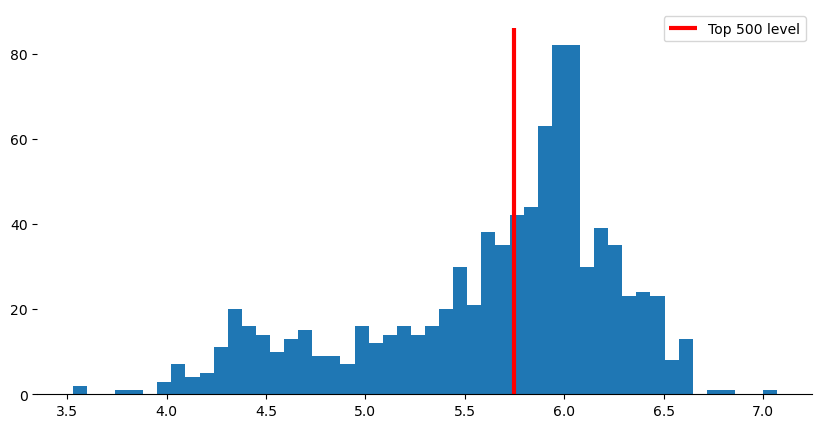

In [46]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(potential, bins=50)
ax.vlines(sorted(potential)[-500], ax.get_ylim()[0], ax.get_ylim()[1], label="Top 500 level", color="r", lw=3)
ax.legend()
sns.despine(left=True)
plt.show()

Based on the observations that there are many predictions near the border area, which could potentially result in mistakes, one approach to address this issue is to gradually decrease the number of predictions near the border. This can be done by reducing the quantity linearly. By analyzing several submissions, it was found that the optimal area for reducing predictions is around 125 galaxies around the border.

In [47]:
x1 = np.zeros(len(test))
x1[potential.argsort()[::-1][:375]] = 100
x1[potential.argsort()[::-1][375:625]] = [100 - i * (50 / 125) for i in range(1, 126)] + [100 - i  * (50 / 125) for i in range(125, 250)]
print("Total low-EEI galaxies energy:", x1[low_eei_idx].sum())
print("Likely increase:", -neg_likely_increase(x1))

Total low-EEI galaxies energy: 6476.8
Likely increase: 1847.7928560450687


Another approach to address the issue of too many predictions near the border is to take into account that there are more predictions outside the border area than inside it. To address this imbalance, we can dilute the predictions more aggressively in a range around the border where the number of predictions is greater than the optimal number. This can help to reduce the number of predictions near the border while preserving the accuracy of the model's predictions.

In [48]:
h = 62.5
x2 = np.zeros(len(test))
x2[potential.argsort()[::-1][:250]] = 100
x2[potential.argsort()[::-1][250:500]] = [100 - i / 250 * (100 - h) for i in range(1, 251)]
x2[potential.argsort()[::-1][500:650]] = [1/3 + h - i / 150 * h for i in range(1, 151)]
print("Total low-EEI galaxies energy:", x2[low_eei_idx].sum())
print("Likely increase:", -neg_likely_increase(x2))

Total low-EEI galaxies energy: 6304.133333333333
Likely increase: 1841.2733620141214


<H3>Final submission average

In [49]:
allocation = (x1 + x2) / 2

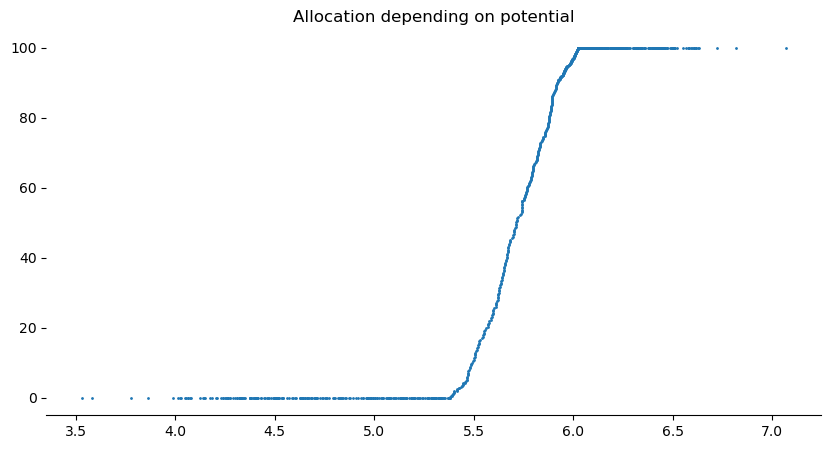

In [50]:
plt.figure(figsize=(10, 5))
plt.title("Allocation depending on potential")
plt.scatter(potential, allocation, s=1)
sns.despine(left=True)
plt.show()

In [51]:
print(f"Total allocated value: {allocation.sum()}")

Total allocated value: 50000.0


<H1>Result

In [52]:
result = pd.DataFrame(columns=[ "pred", "opt_pred"])
# result["Index"] = test.index
result["pred"] = y_pred_test
result["opt_pred"] = allocation

In [53]:
result

,pred,opt_pred
0,0.041843,93.700
1,0.038536,100.000
2,0.038903,99.025
3,0.042146,93.175
4,0.021796,100.000
...,...,...
885,0.036708,100.000
886,0.035036,100.000
887,0.031113,100.000
888,0.045638,82.925
